In [17]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as de
import dedalus.dev as dev
import dedalus.extras.plot_tools as plot_tools
import atmospheres as atmos
from scipy import linalg
import tides
import modes
import parameters as param
import mpi4py.MPI as MPI
import uuid
import logging
import pickle
import pathlib
logger = logging.getLogger(__name__)
%matplotlib notebook

In [2]:
import importlib
importlib.reload(param)

<module 'parameters' from '/Users/kburns/Hg/pg_coupling/compressible/notebooks/parameters.py'>

## Solve 2D linear tide

In [3]:
param.A_tide = 1
domain, problem = tides.linear_tide_2d(param, dtype=np.complex128)
solver = problem.build_solver()
solver.solve()

2018-05-05 15:55:16,519 domain 0/1 DEBUG :: Global coeff shape: [64]
2018-05-05 15:55:16,520 distributor 0/1 DEBUG :: Mesh: []
2018-05-05 15:55:16,526 problems 0/1 DEBUG :: Parsing Eqn 0
2018-05-05 15:55:16,527 problems 0/1 DEBUG ::   Condition: True
2018-05-05 15:55:16,528 problems 0/1 DEBUG ::   LHS string form: dz(pz) + (N2/g)*pz
2018-05-05 15:55:16,529 problems 0/1 DEBUG ::   RHS string form: pz*pz/p/γ
2018-05-05 15:55:16,532 problems 0/1 DEBUG ::   LHS object form: dz(pz) + ((N2*(g**-1))*pz)
2018-05-05 15:55:16,533 problems 0/1 DEBUG ::   RHS object form: ((pz*pz)*(p**-1))*(γ**-1)
2018-05-05 15:55:16,539 problems 0/1 DEBUG ::   L linear form: dz(δpz) + ((N2*(g**-1))*δpz)
2018-05-05 15:55:16,542 problems 0/1 DEBUG ::   dF linear form: ((((pz*pz)*(-1*(p**-2)))*(γ**-1))*δp) + ((((pz*(p**-1))*(γ**-1))*δpz) + (((pz*(p**-1))*(γ**-1))*δpz))
2018-05-05 15:55:16,543 problems 0/1 DEBUG :: Parsing Eqn 1
2018-05-05 15:55:16,545 problems 0/1 DEBUG ::   Condition: True
2018-05-05 15:55:16,546 p

2018-05-05 15:55:17,214 problems 0/1 DEBUG ::   LHS string form: wz - dz(w)
2018-05-05 15:55:17,215 problems 0/1 DEBUG ::   RHS string form: 0
2018-05-05 15:55:17,217 problems 0/1 DEBUG ::   LHS object form: wz + (-1*dz(w))
2018-05-05 15:55:17,217 problems 0/1 DEBUG ::   RHS object form: 0
2018-05-05 15:55:17,219 problems 0/1 DEBUG ::   L linear form: wz + (-1*dz(w))
2018-05-05 15:55:17,219 problems 0/1 DEBUG :: Parsing BC 0
2018-05-05 15:55:17,220 problems 0/1 DEBUG ::   Condition: nx != 0
2018-05-05 15:55:17,221 problems 0/1 DEBUG ::   LHS string form: left(txz/μ)
2018-05-05 15:55:17,221 problems 0/1 DEBUG ::   RHS string form: 0
2018-05-05 15:55:17,222 problems 0/1 DEBUG ::   LHS object form: interp((μ*(dx(w) + uz))*(μ**-1),'z',left)
2018-05-05 15:55:17,223 problems 0/1 DEBUG ::   RHS object form: 0
2018-05-05 15:55:17,226 problems 0/1 DEBUG ::   L linear form: interp((μ*(μ**-1))*dx(w),'z',left) + interp((μ*(μ**-1))*uz,'z',left)
2018-05-05 15:55:17,227 problems 0/1 DEBUG :: Parsing 

2018-05-05 15:55:20,642 basis 0/1 DEBUG :: Building FFTW DCT plan for (dtype, gshape, axis) = (complex128, (63, 128), 1)


In [13]:
# Build systems
X0 = dev.system.FieldSystem(problem.variables, domain)
X1 = dev.system.FieldSystem(problem.variables, domain)
F = dev.system.FieldSystem(problem.variables, domain)
dF = dev.system.FieldSystem(problem.variables, domain)

# Unpack variables
a1, p1, u, w, uz, wz = X0.fields
# Gather operators
dx = domain.bases[0].Differentiate
dz = domain.bases[1].Differentiate
γ = param.γ
μ = param.μ
# Build substitutions
ux = dx(u)
wx = dx(w)
div_u = ux + wz
txx = μ*(2*ux - 2/3*div_u)
txz = μ*(wx + uz)
tzz = μ*(2*wz - 2/3*div_u)
# Build expressions
F1 = - (u*ux + w*uz) - a1*dx(p1) + a1*(dx(txx) + dz(txz))
F2 = - (u*wx + w*wz) - a1*dz(p1) + a1*(dx(txz) + dz(tzz))
F3 = - (u*dx(a1) + w*dz(a1)) +   a1*div_u
F4 = - (u*dx(p1) + w*dz(p1)) - γ*p1*div_u

# Build Frechet differentials
def frechet(F, X0, X1):
    dF = 0
    ep = dev.field.Scalar(name='__epsilon__')
    for x0, x1 in zip(X0.fields, X1.fields):
        dFi = F.replace(x0, x0 + ep*x1)
        dFi = dev.field.Operand.cast(dFi.sym_diff(ep))
        dFi = dFi.replace(ep, 0)
        dF += dFi
    return dF
dF1 = frechet(F1, X0, X1)
dF2 = frechet(F2, X0, X1)
dF3 = frechet(F3, X0, X1)
dF4 = frechet(F4, X0, X1)
# Build handlers
evaluator = dev.evaluator.Evaluator(domain, problem.namespace)
dFe_handler = evaluator.add_system_handler(iter=1, group='dF')
dFb_handler = evaluator.add_system_handler(iter=1, group='dF')
dFe_handler.add_task(dF1)
dFe_handler.add_task(dF2)
dFe_handler.add_task(dF3)
dFe_handler.add_task(dF4)
for i in range(8):
    dFe_handler.add_task(0*a1)
for i in range(4):
    dFb_handler.add_task(0*a1)
dFe = dFe_handler.build_system()
dFb = dFb_handler.build_system()

def compute_dF(iX0, iX1):
    # Copy to prebuilt systems
    iX0.gather()
    iX1.gather()
    np.copyto(X0.data, iX0.data)
    np.copyto(X1.data, iX1.data)
    X0.scatter()
    X1.scatter()
    # Evaluate and precondition dF
    evaluator.evaluate_group('dF')
    for p in solver.pencils:
        pFe = dFe.get_pencil(p)
        pFb = dFb.get_pencil(p)
        if p.G_bc is None:
            dF.set_pencil(p, p.G_eq*pFe)
        else:
            dF.set_pencil(p, p.G_eq*pFe + p.G_bc*pFb)
    dF.scatter()

In [ ]:
force = False
savefile = "coupling_emodes_%i.pkl" %param.Nz

if force or pathlib.Path(savefile).exists():
    # Load modes
    print('Loading modes')
    shortmodes = pickle.load(open("coupling_emodes.pkl", "rb"))
else:
    # Build modes
    print('Building modes')
    krel_list = np.sort(list(np.arange(10)+1)+list(np.arange(10)+0.5))
    eigenmodes = {}
    for krel in krel_list:
        eigenmodes[krel] = modes.compute_eigenmodes(param, krel*param.k_tide, sparse=False)
    # Save modes
    shortmodes = {key: val[:5] for key, val in eigenmodes.items()}
    pickle.dump(shortmodes, open(savefile, "wb"))

Building modes
2018-05-05 16:00:19,624 domain 0/1 DEBUG :: Global coeff shape: [64]
2018-05-05 16:00:19,625 distributor 0/1 DEBUG :: Mesh: []
2018-05-05 16:00:19,627 problems 0/1 DEBUG :: Parsing Eqn 0
2018-05-05 16:00:19,628 problems 0/1 DEBUG ::   Condition: True
2018-05-05 16:00:19,629 problems 0/1 DEBUG ::   LHS string form: dz(pz) + (N2/g)*pz
2018-05-05 16:00:19,629 problems 0/1 DEBUG ::   RHS string form: pz*pz/p/γ
2018-05-05 16:00:19,631 problems 0/1 DEBUG ::   LHS object form: dz(pz) + ((N2*(g**-1))*pz)
2018-05-05 16:00:19,632 problems 0/1 DEBUG ::   RHS object form: ((pz*pz)*(p**-1))*(γ**-1)
2018-05-05 16:00:19,636 problems 0/1 DEBUG ::   L linear form: dz(δpz) + ((N2*(g**-1))*δpz)
2018-05-05 16:00:19,637 problems 0/1 DEBUG ::   dF linear form: ((((pz*pz)*(-1*(p**-2)))*(γ**-1))*δp) + ((((pz*(p**-1))*(γ**-1))*δpz) + (((pz*(p**-1))*(γ**-1))*δpz))
2018-05-05 16:00:19,638 problems 0/1 DEBUG :: Parsing Eqn 1
2018-05-05 16:00:19,639 problems 0/1 DEBUG ::   Condition: True
2018-05-05

2018-05-05 16:00:20,292 problems 0/1 DEBUG ::   L linear form: (((U*(1j*kx))*p1) + (p0z*w)) + ((((γ*p0)*(1j*kx))*u) + ((γ*p0)*wz))
2018-05-05 16:00:20,293 problems 0/1 DEBUG :: Parsing Eqn 4
2018-05-05 16:00:20,294 problems 0/1 DEBUG ::   Condition: True
2018-05-05 16:00:20,294 problems 0/1 DEBUG ::   LHS string form: uz - dz(u)
2018-05-05 16:00:20,295 problems 0/1 DEBUG ::   RHS string form: 0
2018-05-05 16:00:20,297 problems 0/1 DEBUG ::   LHS object form: uz + (-1*dz(u))
2018-05-05 16:00:20,298 problems 0/1 DEBUG ::   RHS object form: 0
2018-05-05 16:00:20,299 problems 0/1 DEBUG ::   M linear form: 0
2018-05-05 16:00:20,301 problems 0/1 DEBUG ::   L linear form: uz + (-1*dz(u))
2018-05-05 16:00:20,302 problems 0/1 DEBUG :: Parsing Eqn 5
2018-05-05 16:00:20,303 problems 0/1 DEBUG ::   Condition: True
2018-05-05 16:00:20,304 problems 0/1 DEBUG ::   LHS string form: wz - dz(w)
2018-05-05 16:00:20,305 problems 0/1 DEBUG ::   RHS string form: 0
2018-05-05 16:00:20,306 problems 0/1 DEBUG 

/Users/kburns/Hg/pg_coupling/compressible/notebooks/modes.py:35: ComplexWarning: Casting complex values to real discards the imaginary part
  energies[i] = E_op.evaluate()['c'][0]


2018-05-05 16:00:24,623 domain 0/1 DEBUG :: Global coeff shape: [64]
2018-05-05 16:00:24,624 distributor 0/1 DEBUG :: Mesh: []
2018-05-05 16:00:24,626 problems 0/1 DEBUG :: Parsing Eqn 0
2018-05-05 16:00:24,627 problems 0/1 DEBUG ::   Condition: True
2018-05-05 16:00:24,628 problems 0/1 DEBUG ::   LHS string form: dz(pz) + (N2/g)*pz
2018-05-05 16:00:24,628 problems 0/1 DEBUG ::   RHS string form: pz*pz/p/γ
2018-05-05 16:00:24,631 problems 0/1 DEBUG ::   LHS object form: dz(pz) + ((N2*(g**-1))*pz)
2018-05-05 16:00:24,631 problems 0/1 DEBUG ::   RHS object form: ((pz*pz)*(p**-1))*(γ**-1)
2018-05-05 16:00:24,637 problems 0/1 DEBUG ::   L linear form: dz(δpz) + ((N2*(g**-1))*δpz)
2018-05-05 16:00:24,640 problems 0/1 DEBUG ::   dF linear form: ((((pz*pz)*(-1*(p**-2)))*(γ**-1))*δp) + ((((pz*(p**-1))*(γ**-1))*δpz) + (((pz*(p**-1))*(γ**-1))*δpz))
2018-05-05 16:00:24,641 problems 0/1 DEBUG :: Parsing Eqn 1
2018-05-05 16:00:24,641 problems 0/1 DEBUG ::   Condition: True
2018-05-05 16:00:24,642 p

2018-05-05 16:00:25,338 problems 0/1 DEBUG ::   L linear form: (((U*(1j*kx))*p1) + (p0z*w)) + ((((γ*p0)*(1j*kx))*u) + ((γ*p0)*wz))
2018-05-05 16:00:25,338 problems 0/1 DEBUG :: Parsing Eqn 4
2018-05-05 16:00:25,339 problems 0/1 DEBUG ::   Condition: True
2018-05-05 16:00:25,340 problems 0/1 DEBUG ::   LHS string form: uz - dz(u)
2018-05-05 16:00:25,341 problems 0/1 DEBUG ::   RHS string form: 0
2018-05-05 16:00:25,341 problems 0/1 DEBUG ::   LHS object form: uz + (-1*dz(u))
2018-05-05 16:00:25,343 problems 0/1 DEBUG ::   RHS object form: 0
2018-05-05 16:00:25,345 problems 0/1 DEBUG ::   M linear form: 0
2018-05-05 16:00:25,346 problems 0/1 DEBUG ::   L linear form: uz + (-1*dz(u))
2018-05-05 16:00:25,348 problems 0/1 DEBUG :: Parsing Eqn 5
2018-05-05 16:00:25,348 problems 0/1 DEBUG ::   Condition: True
2018-05-05 16:00:25,350 problems 0/1 DEBUG ::   LHS string form: wz - dz(w)
2018-05-05 16:00:25,351 problems 0/1 DEBUG ::   RHS string form: 0
2018-05-05 16:00:25,352 problems 0/1 DEBUG 

2018-05-05 16:00:29,756 solvers 0/1 DEBUG :: Beginning NLBVP instantiation
2018-05-05 16:00:29,763 basis 0/1 DEBUG :: Building FFTW DCT plan for (dtype, gshape, axis) = (complex128, (64,), 0)
2018-05-05 16:00:29,791 field 0/1 DEBUG :: Expanded NCC 'N2*(g**-1)' to mode 38 with 20 terms.
2018-05-05 16:00:29,802 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s
2018-05-05 16:00:29,804 solvers 0/1 DEBUG :: Finished NLBVP instantiation
2018-05-05 16:00:29,808 basis 0/1 DEBUG :: Building FFTW DCT plan for (dtype, gshape, axis) = (complex128, (128,), 0)
2018-05-05 16:00:29,889 field 0/1 DEBUG :: Expanded NCC '((pz*pz)*(-1*(p**-2)))*(γ**-1)' to mode 63 with 64 terms.
2018-05-05 16:00:29,965 field 0/1 DEBUG :: Expanded NCC '(pz*(p**-1))*(γ**-1)' to mode 63 with 64 terms.
2018-05-05 16:00:30,042 field 0/1 DEBUG :: Expanded NCC '(pz*(p**-1))*(γ**-1)' to mode 63 with 64 terms.
2018-05-05 16:00:30,051 pencil 0/1 INFO :: Building pencil matrix 1/1 (~10

2018-05-05 16:00:30,393 problems 0/1 DEBUG :: Parsing BC 2
2018-05-05 16:00:30,393 problems 0/1 DEBUG ::   Condition: True
2018-05-05 16:00:30,394 problems 0/1 DEBUG ::   LHS string form: left(w)
2018-05-05 16:00:30,395 problems 0/1 DEBUG ::   RHS string form: 0
2018-05-05 16:00:30,396 problems 0/1 DEBUG ::   LHS object form: interp(w,'z',left)
2018-05-05 16:00:30,397 problems 0/1 DEBUG ::   RHS object form: 0
2018-05-05 16:00:30,398 problems 0/1 DEBUG ::   M linear form: 0
2018-05-05 16:00:30,399 problems 0/1 DEBUG ::   L linear form: interp(w,'z',left)
2018-05-05 16:00:30,399 problems 0/1 DEBUG :: Parsing BC 3
2018-05-05 16:00:30,400 problems 0/1 DEBUG ::   Condition: True
2018-05-05 16:00:30,401 problems 0/1 DEBUG ::   LHS string form: right(w)
2018-05-05 16:00:30,402 problems 0/1 DEBUG ::   RHS string form: 0
2018-05-05 16:00:30,403 problems 0/1 DEBUG ::   LHS object form: interp(w,'z',right)
2018-05-05 16:00:30,403 problems 0/1 DEBUG ::   RHS object form: 0
2018-05-05 16:00:30,405

2018-05-05 16:00:35,330 problems 0/1 DEBUG ::   M linear form: u
2018-05-05 16:00:35,343 problems 0/1 DEBUG ::   L linear form: (((U*(1j*kx))*u) + ((a0*(1j*kx))*p1)) + ((((-1*(a0*((1j*kx)*(μ*(2*(1j*kx))))))*u) + (((-1*(a0*((1j*kx)*(μ*(-1*(0.6666666666666666*(1j*kx)))))))*u) + ((-1*(a0*((1j*kx)*(μ*-0.6666666666666666))))*wz))) + (((-1*(a0*μ))*dz((1j*kx)*w)) + ((-1*(a0*μ))*dz(uz))))
2018-05-05 16:00:35,344 problems 0/1 DEBUG :: Parsing Eqn 1
2018-05-05 16:00:35,345 problems 0/1 DEBUG ::   Condition: True
2018-05-05 16:00:35,346 problems 0/1 DEBUG ::   LHS string form: dt(w) + U*wx + a0*dz(p1) + a1*p0z - a0*(dx(txz) + dz(tzz))
2018-05-05 16:00:35,347 problems 0/1 DEBUG ::   RHS string form: - (u*wx + w*wz) - a1*dz(p1) + a1*(dx(txz) + dz(tzz))
2018-05-05 16:00:35,351 problems 0/1 DEBUG ::   LHS object form: ((((σ*w) + (U*((1j*kx)*w))) + (a0*dz(p1))) + (a1*p0z)) + (-1*(a0*(((1j*kx)*(μ*(((1j*kx)*w) + uz))) + dz(μ*((2*wz) + (-1*(0.6666666666666666*(((1j*kx)*u) + wz))))))))
2018-05-05 16:00:35

2018-05-05 16:00:35,918 field 0/1 DEBUG :: Expanded NCC 'a0z' to mode 33 with 33 terms.
2018-05-05 16:00:35,964 field 0/1 DEBUG :: Expanded NCC '-1*(a0*(1j*kx))' to mode 32 with 32 terms.
2018-05-05 16:00:36,010 field 0/1 DEBUG :: Expanded NCC '-1*a0' to mode 28 with 29 terms.
2018-05-05 16:00:36,064 field 0/1 DEBUG :: Expanded NCC '(γ*p0)*(1j*kx)' to mode 25 with 26 terms.
2018-05-05 16:00:36,105 field 0/1 DEBUG :: Expanded NCC 'γ*p0' to mode 23 with 24 terms.
2018-05-05 16:00:39,678 modes 0/1 INFO :: Max eval mismatch: 0.000000e+00
2018-05-05 16:00:40,033 domain 0/1 DEBUG :: Global coeff shape: [64]
2018-05-05 16:00:40,034 distributor 0/1 DEBUG :: Mesh: []
2018-05-05 16:00:40,037 problems 0/1 DEBUG :: Parsing Eqn 0
2018-05-05 16:00:40,038 problems 0/1 DEBUG ::   Condition: True
2018-05-05 16:00:40,038 problems 0/1 DEBUG ::   LHS string form: dz(pz) + (N2/g)*pz
2018-05-05 16:00:40,039 problems 0/1 DEBUG ::   RHS string form: pz*pz/p/γ
2018-05-05 16:00:40,041 problems 0/1 DEBUG ::   LH

2018-05-05 16:00:40,677 problems 0/1 DEBUG ::   LHS string form: dt(p1) + U*dx(p1) + u*p0x + w*p0z + γ*p0*div_u
2018-05-05 16:00:40,678 problems 0/1 DEBUG ::   RHS string form: - (U*p0x + u*dx(p1) + w*dz(p1)) - γ*p1*div_u
2018-05-05 16:00:40,681 problems 0/1 DEBUG ::   LHS object form: (((σ*p1) + (U*((1j*kx)*p1))) + (w*p0z)) + ((γ*p0)*(((1j*kx)*u) + wz))
2018-05-05 16:00:40,682 problems 0/1 DEBUG ::   RHS object form: (-1*((u*((1j*kx)*p1)) + (w*dz(p1)))) + (-1*((γ*p1)*(((1j*kx)*u) + wz)))
2018-05-05 16:00:40,692 problems 0/1 DEBUG ::   M linear form: p1
2018-05-05 16:00:40,694 problems 0/1 DEBUG ::   L linear form: (((U*(1j*kx))*p1) + (p0z*w)) + ((((γ*p0)*(1j*kx))*u) + ((γ*p0)*wz))
2018-05-05 16:00:40,694 problems 0/1 DEBUG :: Parsing Eqn 4
2018-05-05 16:00:40,695 problems 0/1 DEBUG ::   Condition: True
2018-05-05 16:00:40,696 problems 0/1 DEBUG ::   LHS string form: uz - dz(u)
2018-05-05 16:00:40,697 problems 0/1 DEBUG ::   RHS string form: 0
2018-05-05 16:00:40,698 problems 0/1 DEBUG

2018-05-05 16:00:45,121 problems 0/1 DEBUG :: Parsing BC 1
2018-05-05 16:00:45,122 problems 0/1 DEBUG ::   Condition: True
2018-05-05 16:00:45,122 problems 0/1 DEBUG ::   LHS string form: left(pz)
2018-05-05 16:00:45,123 problems 0/1 DEBUG ::   RHS string form: pz0
2018-05-05 16:00:45,124 problems 0/1 DEBUG ::   LHS object form: interp(pz,'z',left)
2018-05-05 16:00:45,125 problems 0/1 DEBUG ::   RHS object form: pz0
2018-05-05 16:00:45,126 problems 0/1 DEBUG ::   L linear form: interp(δpz,'z',left)
2018-05-05 16:00:45,127 problems 0/1 DEBUG ::   dF linear form: 0
2018-05-05 16:00:45,129 solvers 0/1 DEBUG :: Beginning NLBVP instantiation
2018-05-05 16:00:45,136 basis 0/1 DEBUG :: Building FFTW DCT plan for (dtype, gshape, axis) = (complex128, (64,), 0)
2018-05-05 16:00:45,165 field 0/1 DEBUG :: Expanded NCC 'N2*(g**-1)' to mode 38 with 20 terms.
2018-05-05 16:00:45,175 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2018-05-05 16:00:45,1

2018-05-05 16:00:45,802 problems 0/1 DEBUG ::   Condition: True
2018-05-05 16:00:45,802 problems 0/1 DEBUG ::   LHS string form: right(txz/μ)
2018-05-05 16:00:45,803 problems 0/1 DEBUG ::   RHS string form: 0
2018-05-05 16:00:45,804 problems 0/1 DEBUG ::   LHS object form: interp((μ*(((1j*kx)*w) + uz))*(μ**-1),'z',right)
2018-05-05 16:00:45,805 problems 0/1 DEBUG ::   RHS object form: 0
2018-05-05 16:00:45,807 problems 0/1 DEBUG ::   M linear form: 0j
2018-05-05 16:00:45,810 problems 0/1 DEBUG ::   L linear form: interp(((μ*(1j*kx))*(μ**-1))*w,'z',right) + interp((μ*(μ**-1))*uz,'z',right)
2018-05-05 16:00:45,811 problems 0/1 DEBUG :: Parsing BC 2
2018-05-05 16:00:45,811 problems 0/1 DEBUG ::   Condition: True
2018-05-05 16:00:45,813 problems 0/1 DEBUG ::   LHS string form: left(w)
2018-05-05 16:00:45,815 problems 0/1 DEBUG ::   RHS string form: 0
2018-05-05 16:00:45,816 problems 0/1 DEBUG ::   LHS object form: interp(w,'z',left)
2018-05-05 16:00:45,817 problems 0/1 DEBUG ::   RHS objec

2018-05-05 16:00:50,682 problems 0/1 DEBUG ::   RHS string form: - (u*ux + w*uz) - a1*dx(p1) + a1*(dx(txx) + dz(txz))
2018-05-05 16:00:50,686 problems 0/1 DEBUG ::   LHS object form: (((σ*u) + (U*((1j*kx)*u))) + (a0*((1j*kx)*p1))) + (-1*(a0*(((1j*kx)*(μ*((2*((1j*kx)*u)) + (-1*(0.6666666666666666*(((1j*kx)*u) + wz)))))) + dz(μ*(((1j*kx)*w) + uz)))))
2018-05-05 16:00:50,687 problems 0/1 DEBUG ::   RHS object form: ((-1*((u*((1j*kx)*u)) + (w*uz))) + (-1*(a1*((1j*kx)*p1)))) + (a1*(((1j*kx)*(μ*((2*((1j*kx)*u)) + (-1*(0.6666666666666666*(((1j*kx)*u) + wz)))))) + dz(μ*(((1j*kx)*w) + uz))))
2018-05-05 16:00:50,708 problems 0/1 DEBUG ::   M linear form: u
2018-05-05 16:00:50,721 problems 0/1 DEBUG ::   L linear form: (((U*(1j*kx))*u) + ((a0*(1j*kx))*p1)) + ((((-1*(a0*((1j*kx)*(μ*(2*(1j*kx))))))*u) + (((-1*(a0*((1j*kx)*(μ*(-1*(0.6666666666666666*(1j*kx)))))))*u) + ((-1*(a0*((1j*kx)*(μ*-0.6666666666666666))))*wz))) + (((-1*(a0*μ))*dz((1j*kx)*w)) + ((-1*(a0*μ))*dz(uz))))
2018-05-05 16:00:50,722 pr

2018-05-05 16:00:51,085 field 0/1 DEBUG :: Expanded NCC 'p0z' to mode 26 with 27 terms.
2018-05-05 16:00:51,101 field 0/1 DEBUG :: Expanded NCC '-1*(a0*((1j*kx)*(μ*(1j*kx))))' to mode 10 with 11 terms.
2018-05-05 16:00:51,114 field 0/1 DEBUG :: Expanded NCC '-1*(a0*((1j*kx)*μ))' to mode 7 with 8 terms.
2018-05-05 16:00:51,125 field 0/1 DEBUG :: Expanded NCC '-1*(a0*μ)' to mode 5 with 6 terms.
2018-05-05 16:00:51,136 field 0/1 DEBUG :: Expanded NCC '-1*(a0*μ)' to mode 5 with 6 terms.
2018-05-05 16:00:51,147 field 0/1 DEBUG :: Expanded NCC '-1*(a0*μ)' to mode 5 with 6 terms.
2018-05-05 16:00:51,204 field 0/1 DEBUG :: Expanded NCC 'a0z' to mode 33 with 33 terms.
2018-05-05 16:00:51,248 field 0/1 DEBUG :: Expanded NCC '-1*(a0*(1j*kx))' to mode 32 with 32 terms.
2018-05-05 16:00:51,292 field 0/1 DEBUG :: Expanded NCC '-1*a0' to mode 28 with 29 terms.
2018-05-05 16:00:51,338 field 0/1 DEBUG :: Expanded NCC '(γ*p0)*(1j*kx)' to mode 27 with 28 terms.
2018-05-05 16:00:51,372 field 0/1 DEBUG :: 

2018-05-05 16:00:55,614 problems 0/1 DEBUG ::   LHS object form: (((σ*a1) + (U*((1j*kx)*a1))) + (w*a0z)) + (-1*(a0*(((1j*kx)*u) + wz)))
2018-05-05 16:00:55,615 problems 0/1 DEBUG ::   RHS object form: (-1*((u*((1j*kx)*a1)) + (w*dz(a1)))) + (a1*(((1j*kx)*u) + wz))
2018-05-05 16:00:55,624 problems 0/1 DEBUG ::   M linear form: a1
2018-05-05 16:00:55,627 problems 0/1 DEBUG ::   L linear form: (((U*(1j*kx))*a1) + (a0z*w)) + (((-1*(a0*(1j*kx)))*u) + ((-1*a0)*wz))
2018-05-05 16:00:55,627 problems 0/1 DEBUG :: Parsing Eqn 3
2018-05-05 16:00:55,628 problems 0/1 DEBUG ::   Condition: True
2018-05-05 16:00:55,629 problems 0/1 DEBUG ::   LHS string form: dt(p1) + U*dx(p1) + u*p0x + w*p0z + γ*p0*div_u
2018-05-05 16:00:55,629 problems 0/1 DEBUG ::   RHS string form: - (U*p0x + u*dx(p1) + w*dz(p1)) - γ*p1*div_u
2018-05-05 16:00:55,632 problems 0/1 DEBUG ::   LHS object form: (((σ*p1) + (U*((1j*kx)*p1))) + (w*p0z)) + ((γ*p0)*(((1j*kx)*u) + wz))
2018-05-05 16:00:55,633 problems 0/1 DEBUG ::   RHS obje

2018-05-05 16:00:59,787 problems 0/1 DEBUG :: Parsing BC 0
2018-05-05 16:00:59,788 problems 0/1 DEBUG ::   Condition: True
2018-05-05 16:00:59,789 problems 0/1 DEBUG ::   LHS string form: left(p)
2018-05-05 16:00:59,790 problems 0/1 DEBUG ::   RHS string form: p0
2018-05-05 16:00:59,791 problems 0/1 DEBUG ::   LHS object form: interp(p,'z',left)
2018-05-05 16:00:59,792 problems 0/1 DEBUG ::   RHS object form: p0
2018-05-05 16:00:59,793 problems 0/1 DEBUG ::   L linear form: interp(δp,'z',left)
2018-05-05 16:00:59,794 problems 0/1 DEBUG ::   dF linear form: 0
2018-05-05 16:00:59,795 problems 0/1 DEBUG :: Parsing BC 1
2018-05-05 16:00:59,796 problems 0/1 DEBUG ::   Condition: True
2018-05-05 16:00:59,797 problems 0/1 DEBUG ::   LHS string form: left(pz)
2018-05-05 16:00:59,798 problems 0/1 DEBUG ::   RHS string form: pz0
2018-05-05 16:00:59,799 problems 0/1 DEBUG ::   LHS object form: interp(pz,'z',left)
2018-05-05 16:00:59,800 problems 0/1 DEBUG ::   RHS object form: pz0
2018-05-05 16:0

2018-05-05 16:01:00,418 problems 0/1 DEBUG ::   RHS string form: 0
2018-05-05 16:01:00,420 problems 0/1 DEBUG ::   LHS object form: interp((μ*(((1j*kx)*w) + uz))*(μ**-1),'z',left)
2018-05-05 16:01:00,420 problems 0/1 DEBUG ::   RHS object form: 0
2018-05-05 16:01:00,422 problems 0/1 DEBUG ::   M linear form: 0j
2018-05-05 16:01:00,425 problems 0/1 DEBUG ::   L linear form: interp(((μ*(1j*kx))*(μ**-1))*w,'z',left) + interp((μ*(μ**-1))*uz,'z',left)
2018-05-05 16:01:00,426 problems 0/1 DEBUG :: Parsing BC 1
2018-05-05 16:01:00,426 problems 0/1 DEBUG ::   Condition: True
2018-05-05 16:01:00,427 problems 0/1 DEBUG ::   LHS string form: right(txz/μ)
2018-05-05 16:01:00,428 problems 0/1 DEBUG ::   RHS string form: 0
2018-05-05 16:01:00,430 problems 0/1 DEBUG ::   LHS object form: interp((μ*(((1j*kx)*w) + uz))*(μ**-1),'z',right)
2018-05-05 16:01:00,430 problems 0/1 DEBUG ::   RHS object form: 0
2018-05-05 16:01:00,433 problems 0/1 DEBUG ::   M linear form: 0j
2018-05-05 16:01:00,435 problems 0

2018-05-05 16:01:04,963 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+02/s
2018-05-05 16:01:04,966 atmospheres 0/1 INFO :: Perturbation norm: 2.556597258469529e-15
2018-05-05 16:01:04,970 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2018-05-05 16:01:04,972 problems 0/1 DEBUG :: Parsing Eqn 0
2018-05-05 16:01:04,972 problems 0/1 DEBUG ::   Condition: True
2018-05-05 16:01:04,973 problems 0/1 DEBUG ::   LHS string form: dt(u) + U*ux + a0*dx(p1) + a1*p0x - a0*(dx(txx) + dz(txz))
2018-05-05 16:01:04,974 problems 0/1 DEBUG ::   RHS string form: - (u*ux + w*uz) - a1*dx(p1) + a1*(dx(txx) + dz(txz))
2018-05-05 16:01:04,978 problems 0/1 DEBUG ::   LHS object form: (((σ*u) + (U*((1j*kx)*u))) + (a0*((1j*kx)*p1))) + (-1*(a0*(((1j*kx)*(μ*((2*((1j*kx)*u)) + (-1*(0.6666666666666666*(((1j*kx)*u) + wz)))))) + dz(μ*(((1j*kx)*w) + uz)))))
2018-05-05 16:01:04,979 problems 0/1 DEBUG ::   RHS object form: ((-1*((u*((1j*kx)*u)) + (w*u

2018-05-05 16:01:05,261 field 0/1 DEBUG :: Expanded NCC '-1*(a0*((1j*kx)*(μ*(-1*(0.6666666666666666*(1j*kx))))))' to mode 10 with 11 terms.
2018-05-05 16:01:05,276 field 0/1 DEBUG :: Expanded NCC '-1*(a0*((1j*kx)*(μ*-0.6666666666666666)))' to mode 7 with 8 terms.
2018-05-05 16:01:05,286 field 0/1 DEBUG :: Expanded NCC '-1*(a0*μ)' to mode 5 with 6 terms.
2018-05-05 16:01:05,296 field 0/1 DEBUG :: Expanded NCC '-1*(a0*μ)' to mode 5 with 6 terms.
2018-05-05 16:01:05,342 field 0/1 DEBUG :: Expanded NCC 'a0' to mode 28 with 29 terms.
2018-05-05 16:01:05,385 field 0/1 DEBUG :: Expanded NCC 'p0z' to mode 26 with 27 terms.
2018-05-05 16:01:05,402 field 0/1 DEBUG :: Expanded NCC '-1*(a0*((1j*kx)*(μ*(1j*kx))))' to mode 10 with 11 terms.
2018-05-05 16:01:05,416 field 0/1 DEBUG :: Expanded NCC '-1*(a0*((1j*kx)*μ))' to mode 8 with 9 terms.
2018-05-05 16:01:05,426 field 0/1 DEBUG :: Expanded NCC '-1*(a0*μ)' to mode 5 with 6 terms.
2018-05-05 16:01:05,437 field 0/1 DEBUG :: Expanded NCC '-1*(a0*μ)' t

2018-05-05 16:01:09,877 problems 0/1 DEBUG :: Parsing Eqn 2
2018-05-05 16:01:09,878 problems 0/1 DEBUG ::   Condition: True
2018-05-05 16:01:09,879 problems 0/1 DEBUG ::   LHS string form: dt(a1) + U*dx(a1) + u*a0x + w*a0z -   a0*div_u
2018-05-05 16:01:09,880 problems 0/1 DEBUG ::   RHS string form: - (U*a0x + u*dx(a1) + w*dz(a1)) +   a1*div_u
2018-05-05 16:01:09,882 problems 0/1 DEBUG ::   LHS object form: (((σ*a1) + (U*((1j*kx)*a1))) + (w*a0z)) + (-1*(a0*(((1j*kx)*u) + wz)))
2018-05-05 16:01:09,883 problems 0/1 DEBUG ::   RHS object form: (-1*((u*((1j*kx)*a1)) + (w*dz(a1)))) + (a1*(((1j*kx)*u) + wz))
2018-05-05 16:01:09,892 problems 0/1 DEBUG ::   M linear form: a1
2018-05-05 16:01:09,893 problems 0/1 DEBUG ::   L linear form: (((U*(1j*kx))*a1) + (a0z*w)) + (((-1*(a0*(1j*kx)))*u) + ((-1*a0)*wz))
2018-05-05 16:01:09,894 problems 0/1 DEBUG :: Parsing Eqn 3
2018-05-05 16:01:09,895 problems 0/1 DEBUG ::   Condition: True
2018-05-05 16:01:09,896 problems 0/1 DEBUG ::   LHS string form: dt

2018-05-05 16:01:14,332 problems 0/1 DEBUG ::   RHS string form: 0
2018-05-05 16:01:14,333 problems 0/1 DEBUG ::   LHS object form: dz(p) + (-1*pz)
2018-05-05 16:01:14,334 problems 0/1 DEBUG ::   RHS object form: 0
2018-05-05 16:01:14,336 problems 0/1 DEBUG ::   L linear form: dz(δp) + (-1*δpz)
2018-05-05 16:01:14,337 problems 0/1 DEBUG ::   dF linear form: 0
2018-05-05 16:01:14,338 problems 0/1 DEBUG :: Parsing BC 0
2018-05-05 16:01:14,338 problems 0/1 DEBUG ::   Condition: True
2018-05-05 16:01:14,339 problems 0/1 DEBUG ::   LHS string form: left(p)
2018-05-05 16:01:14,340 problems 0/1 DEBUG ::   RHS string form: p0
2018-05-05 16:01:14,340 problems 0/1 DEBUG ::   LHS object form: interp(p,'z',left)
2018-05-05 16:01:14,341 problems 0/1 DEBUG ::   RHS object form: p0
2018-05-05 16:01:14,342 problems 0/1 DEBUG ::   L linear form: interp(δp,'z',left)
2018-05-05 16:01:14,343 problems 0/1 DEBUG ::   dF linear form: 0
2018-05-05 16:01:14,344 problems 0/1 DEBUG :: Parsing BC 1
2018-05-05 16:

2018-05-05 16:01:14,972 problems 0/1 DEBUG ::   RHS object form: 0
2018-05-05 16:01:14,974 problems 0/1 DEBUG ::   M linear form: 0
2018-05-05 16:01:14,975 problems 0/1 DEBUG ::   L linear form: wz + (-1*dz(w))
2018-05-05 16:01:14,976 problems 0/1 DEBUG :: Parsing BC 0
2018-05-05 16:01:14,976 problems 0/1 DEBUG ::   Condition: True
2018-05-05 16:01:14,977 problems 0/1 DEBUG ::   LHS string form: left(txz/μ)
2018-05-05 16:01:14,978 problems 0/1 DEBUG ::   RHS string form: 0
2018-05-05 16:01:14,979 problems 0/1 DEBUG ::   LHS object form: interp((μ*(((1j*kx)*w) + uz))*(μ**-1),'z',left)
2018-05-05 16:01:14,980 problems 0/1 DEBUG ::   RHS object form: 0
2018-05-05 16:01:14,982 problems 0/1 DEBUG ::   M linear form: 0j
2018-05-05 16:01:14,985 problems 0/1 DEBUG ::   L linear form: interp(((μ*(1j*kx))*(μ**-1))*w,'z',left) + interp((μ*(μ**-1))*uz,'z',left)
2018-05-05 16:01:14,985 problems 0/1 DEBUG :: Parsing BC 1
2018-05-05 16:01:14,986 problems 0/1 DEBUG ::   Condition: True
2018-05-05 16:0

2018-05-05 16:01:19,566 atmospheres 0/1 INFO :: Perturbation norm: 1.455782802264421e-07
2018-05-05 16:01:19,631 field 0/1 DEBUG :: Expanded NCC '((pz*pz)*(-1*(p**-2)))*(γ**-1)' to mode 40 with 41 terms.
2018-05-05 16:01:19,684 field 0/1 DEBUG :: Expanded NCC '(pz*(p**-1))*(γ**-1)' to mode 38 with 39 terms.
2018-05-05 16:01:19,737 field 0/1 DEBUG :: Expanded NCC '(pz*(p**-1))*(γ**-1)' to mode 38 with 39 terms.
2018-05-05 16:01:19,747 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s
2018-05-05 16:01:19,750 atmospheres 0/1 INFO :: Perturbation norm: 2.556597258469529e-15
2018-05-05 16:01:19,754 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2018-05-05 16:01:19,755 problems 0/1 DEBUG :: Parsing Eqn 0
2018-05-05 16:01:19,756 problems 0/1 DEBUG ::   Condition: True
2018-05-05 16:01:19,758 problems 0/1 DEBUG ::   LHS string form: dt(u) + U*ux + a0*dx(p1) + a1*p0x - a0*(dx(txx) + dz(txz))
2018-05-05 16:01:19,758 proble

2018-05-05 16:01:19,935 problems 0/1 DEBUG ::   L linear form: interp(w,'z',right)
2018-05-05 16:01:19,936 solvers 0/1 DEBUG :: Beginning EVP instantiation
2018-05-05 16:01:19,938 solvers 0/1 DEBUG :: Finished EVP instantiation
2018-05-05 16:01:19,985 field 0/1 DEBUG :: Expanded NCC 'a0*(1j*kx)' to mode 34 with 33 terms.
2018-05-05 16:01:20,006 field 0/1 DEBUG :: Expanded NCC '-1*(a0*((1j*kx)*(μ*(2*(1j*kx)))))' to mode 13 with 14 terms.
2018-05-05 16:01:20,024 field 0/1 DEBUG :: Expanded NCC '-1*(a0*((1j*kx)*(μ*(-1*(0.6666666666666666*(1j*kx))))))' to mode 10 with 11 terms.
2018-05-05 16:01:20,038 field 0/1 DEBUG :: Expanded NCC '-1*(a0*((1j*kx)*(μ*-0.6666666666666666)))' to mode 8 with 9 terms.
2018-05-05 16:01:20,048 field 0/1 DEBUG :: Expanded NCC '-1*(a0*μ)' to mode 5 with 6 terms.
2018-05-05 16:01:20,060 field 0/1 DEBUG :: Expanded NCC '-1*(a0*μ)' to mode 5 with 6 terms.
2018-05-05 16:01:20,110 field 0/1 DEBUG :: Expanded NCC 'a0' to mode 28 with 29 terms.
2018-05-05 16:01:20,149 

2018-05-05 16:01:24,783 problems 0/1 DEBUG ::   RHS object form: ((-1*((u*((1j*kx)*w)) + (w*wz))) + (-1*(a1*dz(p1)))) + (a1*(((1j*kx)*(μ*(((1j*kx)*w) + uz))) + dz(μ*((2*wz) + (-1*(0.6666666666666666*(((1j*kx)*u) + wz)))))))
2018-05-05 16:01:24,803 problems 0/1 DEBUG ::   M linear form: w
2018-05-05 16:01:24,820 problems 0/1 DEBUG ::   L linear form: ((((U*(1j*kx))*w) + (a0*dz(p1))) + (p0z*a1)) + ((((-1*(a0*((1j*kx)*(μ*(1j*kx)))))*w) + ((-1*(a0*((1j*kx)*μ)))*uz)) + (((-1*(a0*μ))*dz(2*wz)) + (((-1*(a0*μ))*dz((-1*(0.6666666666666666*(1j*kx)))*u)) + ((-1*(a0*μ))*dz(-0.6666666666666666*wz)))))
2018-05-05 16:01:24,820 problems 0/1 DEBUG :: Parsing Eqn 2
2018-05-05 16:01:24,821 problems 0/1 DEBUG ::   Condition: True
2018-05-05 16:01:24,822 problems 0/1 DEBUG ::   LHS string form: dt(a1) + U*dx(a1) + u*a0x + w*a0z -   a0*div_u
2018-05-05 16:01:24,823 problems 0/1 DEBUG ::   RHS string form: - (U*a0x + u*dx(a1) + w*dz(a1)) +   a1*div_u
2018-05-05 16:01:24,824 problems 0/1 DEBUG ::   LHS object

2018-05-05 16:01:29,056 problems 0/1 DEBUG ::   RHS object form: ((pz*pz)*(p**-1))*(γ**-1)
2018-05-05 16:01:29,061 problems 0/1 DEBUG ::   L linear form: dz(δpz) + ((N2*(g**-1))*δpz)
2018-05-05 16:01:29,064 problems 0/1 DEBUG ::   dF linear form: ((((pz*pz)*(-1*(p**-2)))*(γ**-1))*δp) + ((((pz*(p**-1))*(γ**-1))*δpz) + (((pz*(p**-1))*(γ**-1))*δpz))
2018-05-05 16:01:29,065 problems 0/1 DEBUG :: Parsing Eqn 1
2018-05-05 16:01:29,066 problems 0/1 DEBUG ::   Condition: True
2018-05-05 16:01:29,067 problems 0/1 DEBUG ::   LHS string form: dz(p) - pz
2018-05-05 16:01:29,068 problems 0/1 DEBUG ::   RHS string form: 0
2018-05-05 16:01:29,069 problems 0/1 DEBUG ::   LHS object form: dz(p) + (-1*pz)
2018-05-05 16:01:29,070 problems 0/1 DEBUG ::   RHS object form: 0
2018-05-05 16:01:29,072 problems 0/1 DEBUG ::   L linear form: dz(δp) + (-1*δpz)
2018-05-05 16:01:29,073 problems 0/1 DEBUG ::   dF linear form: 0
2018-05-05 16:01:29,074 problems 0/1 DEBUG :: Parsing BC 0
2018-05-05 16:01:29,075 proble

2018-05-05 16:01:29,725 problems 0/1 DEBUG ::   RHS object form: 0
2018-05-05 16:01:29,727 problems 0/1 DEBUG ::   M linear form: 0
2018-05-05 16:01:29,728 problems 0/1 DEBUG ::   L linear form: uz + (-1*dz(u))
2018-05-05 16:01:29,729 problems 0/1 DEBUG :: Parsing Eqn 5
2018-05-05 16:01:29,730 problems 0/1 DEBUG ::   Condition: True
2018-05-05 16:01:29,731 problems 0/1 DEBUG ::   LHS string form: wz - dz(w)
2018-05-05 16:01:29,732 problems 0/1 DEBUG ::   RHS string form: 0
2018-05-05 16:01:29,733 problems 0/1 DEBUG ::   LHS object form: wz + (-1*dz(w))
2018-05-05 16:01:29,733 problems 0/1 DEBUG ::   RHS object form: 0
2018-05-05 16:01:29,735 problems 0/1 DEBUG ::   M linear form: 0
2018-05-05 16:01:29,737 problems 0/1 DEBUG ::   L linear form: wz + (-1*dz(w))
2018-05-05 16:01:29,738 problems 0/1 DEBUG :: Parsing BC 0
2018-05-05 16:01:29,739 problems 0/1 DEBUG ::   Condition: True
2018-05-05 16:01:29,739 problems 0/1 DEBUG ::   LHS string form: left(txz/μ)
2018-05-05 16:01:29,740 proble

2018-05-05 16:01:34,254 basis 0/1 DEBUG :: Building FFTW DCT plan for (dtype, gshape, axis) = (complex128, (128,), 0)
2018-05-05 16:01:34,338 field 0/1 DEBUG :: Expanded NCC '((pz*pz)*(-1*(p**-2)))*(γ**-1)' to mode 63 with 64 terms.
2018-05-05 16:01:34,422 field 0/1 DEBUG :: Expanded NCC '(pz*(p**-1))*(γ**-1)' to mode 63 with 64 terms.
2018-05-05 16:01:34,500 field 0/1 DEBUG :: Expanded NCC '(pz*(p**-1))*(γ**-1)' to mode 63 with 64 terms.
2018-05-05 16:01:34,509 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2018-05-05 16:01:34,512 atmospheres 0/1 INFO :: Perturbation norm: 1.455782802264421e-07
2018-05-05 16:01:34,574 field 0/1 DEBUG :: Expanded NCC '((pz*pz)*(-1*(p**-2)))*(γ**-1)' to mode 40 with 41 terms.
2018-05-05 16:01:34,630 field 0/1 DEBUG :: Expanded NCC '(pz*(p**-1))*(γ**-1)' to mode 38 with 39 terms.
2018-05-05 16:01:34,682 field 0/1 DEBUG :: Expanded NCC '(pz*(p**-1))*(γ**-1)' to mode 38 with 39 terms.
2018-05-05 16:01:34,6

2018-05-05 16:01:34,879 problems 0/1 DEBUG ::   L linear form: interp(w,'z',left)
2018-05-05 16:01:34,880 problems 0/1 DEBUG :: Parsing BC 3
2018-05-05 16:01:34,881 problems 0/1 DEBUG ::   Condition: True
2018-05-05 16:01:34,881 problems 0/1 DEBUG ::   LHS string form: right(w)
2018-05-05 16:01:34,882 problems 0/1 DEBUG ::   RHS string form: 0
2018-05-05 16:01:34,883 problems 0/1 DEBUG ::   LHS object form: interp(w,'z',right)
2018-05-05 16:01:34,884 problems 0/1 DEBUG ::   RHS object form: 0
2018-05-05 16:01:34,886 problems 0/1 DEBUG ::   M linear form: 0
2018-05-05 16:01:34,887 problems 0/1 DEBUG ::   L linear form: interp(w,'z',right)
2018-05-05 16:01:34,888 solvers 0/1 DEBUG :: Beginning EVP instantiation
2018-05-05 16:01:34,890 solvers 0/1 DEBUG :: Finished EVP instantiation
2018-05-05 16:01:34,945 field 0/1 DEBUG :: Expanded NCC 'a0*(1j*kx)' to mode 34 with 33 terms.
2018-05-05 16:01:34,970 field 0/1 DEBUG :: Expanded NCC '-1*(a0*((1j*kx)*(μ*(2*(1j*kx)))))' to mode 13 with 14 ter

## Tide-Tide coupling

<IPython.core.display.Javascript object>


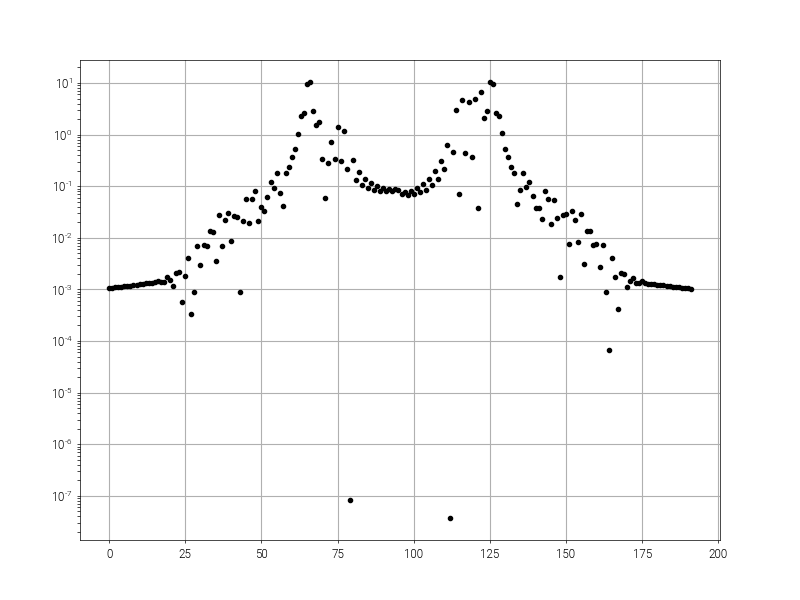

<IPython.core.display.Javascript object>


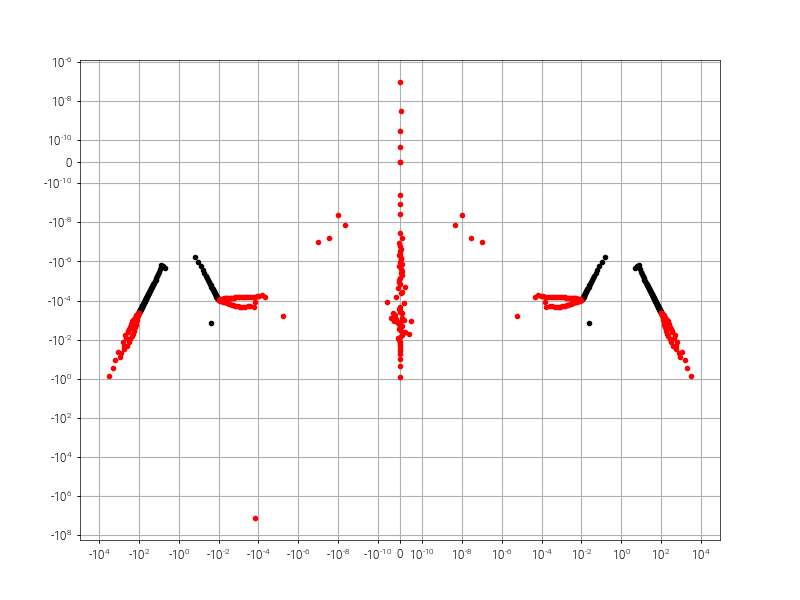

In [50]:
krel_b = 2.0
p_b = solver.pencils[int(krel_b*param.k_tide/(2*np.pi/param.Lx))]
evals_b, evecs_b, adj_evals_b, adj_evecs_b, proj_b, sevp, pevp = eigenmodes[krel_b]

# Compute coupling coefficients b:LL
filt_b = (np.abs(evals_b.real) > 1e-2) * (np.abs(evals_b.real) < 1e2)

compute_F(solver.state, solver.state)
K_bLL = adj_evecs_b[:,filt_b].conj().T @ F.get_pencil(p_b)

plt.figure()
plt.plot(np.abs(K_bLL), '.k')
#plt.xscale('symlog', linthreshx=1e-10)
plt.yscale('log')#, linthreshy=1e-10)
plt.grid()

plt.figure()
plt.plot(evals_b[filt_b].real, evals_b[filt_b].imag, '.k')
plt.plot(evals_b[~filt_b].real, evals_b[~filt_b].imag, '.r')
plt.xscale('symlog', linthreshx=1e-10)
plt.yscale('symlog', linthreshy=1e-10)
plt.grid()

## Tide-wave self-coupling

In [13]:
def get_pencil(krel):
    index = int(krel * param.k_tide / (2*np.pi/param.Lx))
    return solver.pencils[index]

#krel_list = [1,2,3,4,5,6,7,8,9,10]
krel_list = np.sort(list(np.arange(10)+1)+list(np.arange(10)+0.5))
freq_g_imag_cut = -2e-4
freq_g_real_cut = 1e-3
freq_p_real_cut = 2e2
def gen_filt(freqs):
    return ((np.abs(freqs.real) < freq_p_real_cut) * 
            (np.abs(freqs.real) > freq_g_real_cut) * 
            ((np.abs(freqs.real) > 1) + (freqs.imag > freq_g_imag_cut)))

<IPython.core.display.Javascript object>


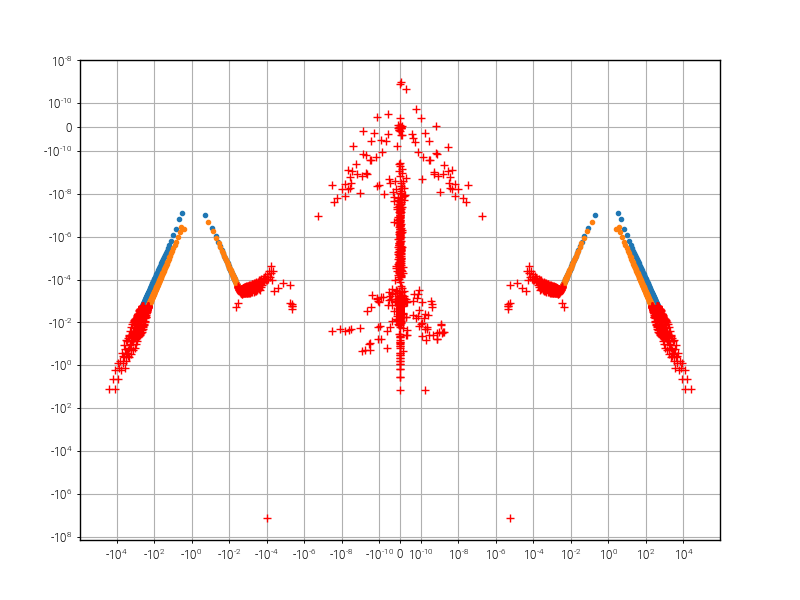

In [14]:
krel_list = [0.5, 1.0]

N = {}
plt.figure()
for krel in krel_list:
    freqs = 1j * shortmodes[krel][0]
    filt = gen_filt(freqs)
    N[krel] = np.sum(filt)
    plt.plot(freqs[filt].real/krel, freqs[filt].imag, '.')
    plt.plot(freqs[~filt].real/krel, freqs[~filt].imag, '+r')
plt.xscale('symlog', linthreshx=1e-10)
plt.yscale('symlog', linthreshy=1e-10)
plt.grid()

In [16]:
state_wave = dev.system.FieldSystem(problem.variables, domain)

K_bLc_dict = {}
for krel_c in krel_list:
    # Get c pencil data
    p_c = get_pencil(krel_c)
    evals_c, evecs_c, adj_evals_c, adj_evecs_c, proj_c = shortmodes[krel_c]
    filt_c = gen_filt(1j*evals_c)
    N_c = np.sum(filt_c)
    # Compute coupling coefficients
    for j in range(N_c):
        # Set c state
        state_wave.data[:] = 0
        state_wave.set_pencil(p_c, evecs_c[:,filt_c][:,j])
        state_wave.scatter()
        # Compute dF
        compute_dF(solver.state, state_wave)
        for krel_b in krel_list:
            # Shortcut k selection rule
            if (abs(krel_b + krel_c) != 1) and (abs(krel_b - krel_c) != 1):
                continue
            # Get b pencil data
            p_b = get_pencil(krel_b)
            evals_b, evecs_b, adj_evals_b, adj_evecs_b, proj_b = shortmodes[krel_b]
            filt_b = gen_filt(1j*evals_b)
            N_b = np.sum(filt_b)
            # Build coupling coefficient matrix
            if (krel_b, krel_c) not in K_bLc_dict:
                K_bLc = np.zeros((N_b, N_c), dtype=np.complex128)
                K_bLc_dict[(krel_b, krel_c)] = K_bLc
            else:
                K_bLc = K_bLc_dict[(krel_b, krel_c)]
            # Compute coupling coefficients
            K_bLc[:,j] = adj_evecs_b[:,filt_b].conj().T @ dF.get_pencil(p_b)

$$
(a e^{ikx} + a^* e^{-ikx}) (b e^{imx} + b^* e^{-imx}) = a b e^{i(k+m)x} + a b^* e^{i(k-m)x} + a^* b e^{i(-k+m)x} + a^* b^* e^{i(-k-m)x}
$$

<IPython.core.display.Javascript object>


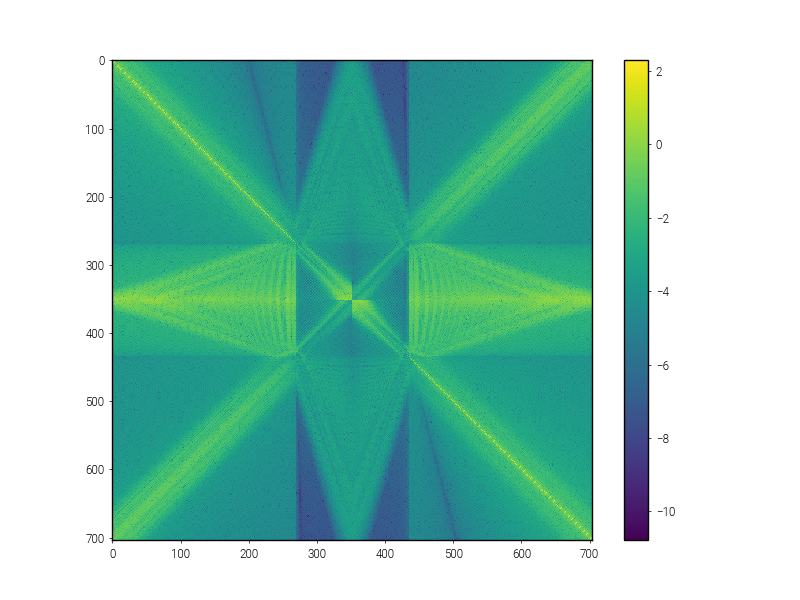

In [17]:
# Build eigenmode-time-evolution matrix Q
A_scale = 9e-3
#krel_list = [1,2,3,4,5,6,7,8,9,10]
krel_list = [0.5]#,1.0,1.5,2.0,2.5,3.0,3.5,4.0]

def real_equiv(M):
    # (Mr + i Mi) (Xr + i Xi) = (Mr Xr - Mi Xi) + i (Mi Xr + Mr Xi)
    Mr = M.real
    Mi = M.imag
    p00 = np.array([[1, 0], [0, 0]])
    p01 = np.array([[0, 1], [0, 0]])
    p10 = np.array([[0, 0], [1, 0]])
    p11 = np.array([[0, 0], [0, 1]])
    return np.kron(Mr, p00) - np.kron(Mi, p01) + np.kron(Mi, p10) + np.kron(Mr, p11)

def real_equiv_conj(M):
    # (Mr + i Mi) (Xr - i Xi) = (Mr Xr + Mi Xi) + i (Mi Xr - Mr Xi)
    Mr = M.real
    Mi = M.imag
    p00 = np.array([[1, 0], [0, 0]])
    p01 = np.array([[0, 1], [0, 0]])
    p10 = np.array([[0, 0], [1, 0]])
    p11 = np.array([[0, 0], [0, 1]])
    return np.kron(Mr, p00) + np.kron(Mi, p01) + np.kron(Mi, p10) - np.kron(Mr, p11)

convert_real = (0.5 in krel_list)

Q = []
for kb in krel_list:
    Qb = []
    for kc in krel_list:
        if (1 + kc == kb) or (-1 + kc == kb):
            Qbc = A_scale * K_bLc_dict[(kb,kc)]
            if convert_real:
                Qbc = real_equiv(Qbc)
        elif (1 - kc == kb):
            Qbc = A_scale * K_bLc_dict[(kb,kc)]
            if convert_real:
                Qbc = real_equiv_conj(Qbc)
            else:
                raise
        else:
            Qbc = np.zeros((N[kb], N[kc]), dtype=np.complex128)
            if convert_real:
                Qbc = real_equiv(Qbc)
        if kb == kc:
            evals = shortmodes[kb][0]
            filt = gen_filt(1j*evals)
            # Shift frequencies into comoving frame where tide is time-independent
            Qbb = np.diag(evals[filt] - (-1j*kb*param.ω_tide))
            if convert_real:
                Qbb = real_equiv(Qbb)
            Qbc += Qbb
        Qb.append(Qbc)
    Q.append(Qb)
Q = np.block(Q)

# Q[:2*212,:] *= 1e-2
# Q[2*212+2:,:] *= 1e-2
# Q[:,:2*212] *= 1e-2
# Q[:,2*212+2:] *= 1e-2

# Plot Q
plt.figure()
plt.imshow(np.log10(np.abs(Q)), cmap='viridis')
plt.colorbar()

In [18]:
# Find eigenmodes of Q
Q_evals, Q_evecs = linalg.eig(Q)
Q_freqs = 1j * Q_evals

<IPython.core.display.Javascript object>


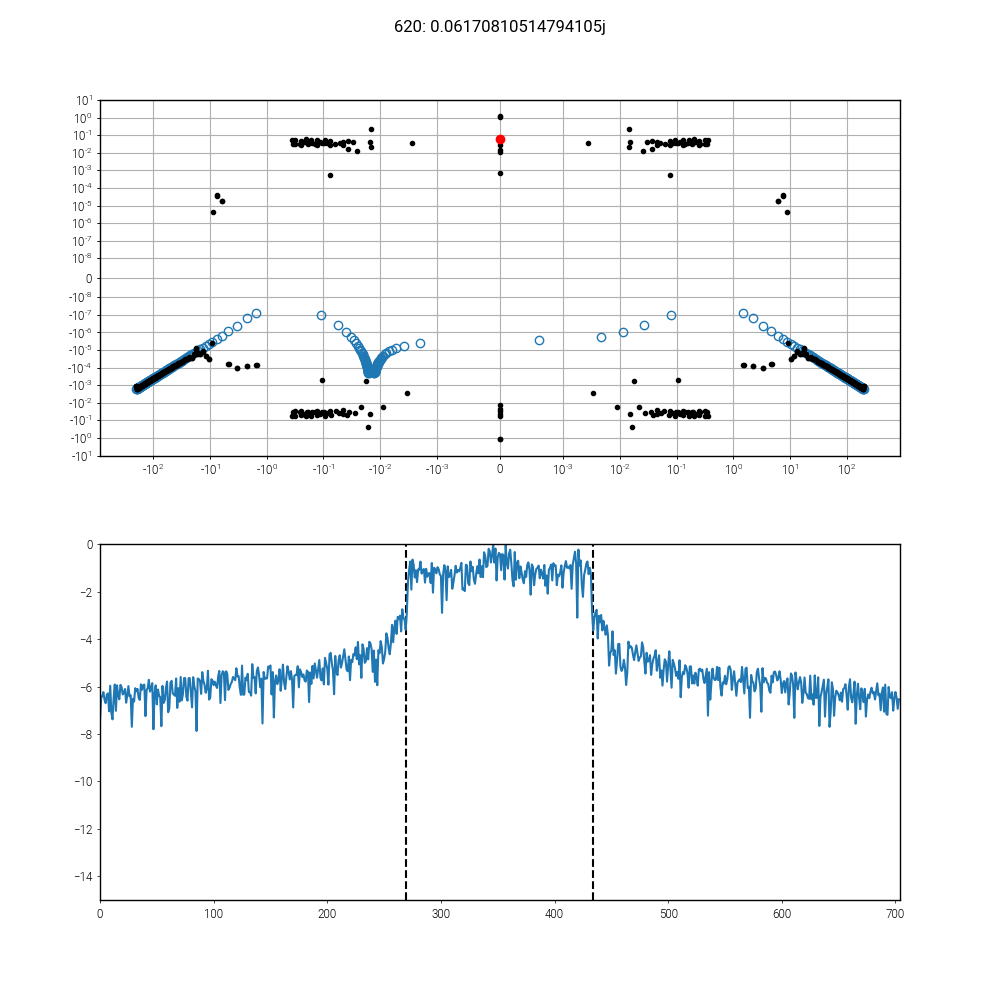

8

In [20]:
if convert_real:
    item = 2
else:
    item = 1

# Plot eigenvalues of Q
fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot2grid((2,1), (0,0))
for krel in krel_list:
    freqs = 1j * shortmodes[krel][0]
    filt = gen_filt(freqs)
    ax1.plot(freqs[filt].real-krel*param.ω_tide, freqs[filt].imag, 'o', mfc='none')
plt_Q, = ax1.plot(Q_freqs.real, Q_freqs.imag, '.k', picker=2)
ax1.set_xscale('symlog', linthreshx=1e-3)
ax1.set_yscale('symlog', linthreshy=1e-8)
plt.grid()
active_dot, = ax1.plot(0, 0, 'or')
active_ev = fig.suptitle('')

# Plot mode separations
ax2 = plt.subplot2grid((2,1), (1,0))
def plot_seps():
    n = 0
    for krel in krel_list:
        # Block separator
        if krel != krel_list[0]:
            ax2.axvline(item*n-0.5, c='k', zorder=-1)
        # P-G separator
        freqs = 1j * shortmodes[krel][0]
        filt = gen_filt(freqs)
        ni = np.sum(freqs[filt].real < -1)
        ax2.axvline(item*n+item*ni-0.5, c='k', ls='dashed', zorder=-1)
        ni = np.sum(freqs[filt].real < 1)
        ax2.axvline(item*n+item*ni-0.5, c='k', ls='dashed', zorder=-1)
        n += N[krel]
    ax2.set_xlim(0, item*n)
    ax2.set_ylim(-15,0)

def plot_mode(event):
    # Update active eigenvalue
    Xm, Ym = event.mouseevent.x, event.mouseevent.y
    x = plt_Q.get_xdata()
    y = plt_Q.get_ydata()
    XY = ax1.transData.transform(np.array([x,y]).T)
    dXY = XY - np.array([Xm, Ym])
    D = np.sum(dXY**2, axis=1)
    index = np.argmin(D)
    freq = Q_freqs[index]
    active_dot.set_xdata([x[index]])
    active_dot.set_ydata([y[index]])
    active_ev.set_text('%i: %s' %(index, freq))
    # Plot mode
    ax2.cla()
    evec = Q_evecs[:,index]
    evec = evec / np.max(np.abs(evec))
    ax2.plot(np.log10(np.abs(evec)))
    plot_seps()

fig.canvas.mpl_connect('pick_event', plot_mode)

<IPython.core.display.Javascript object>


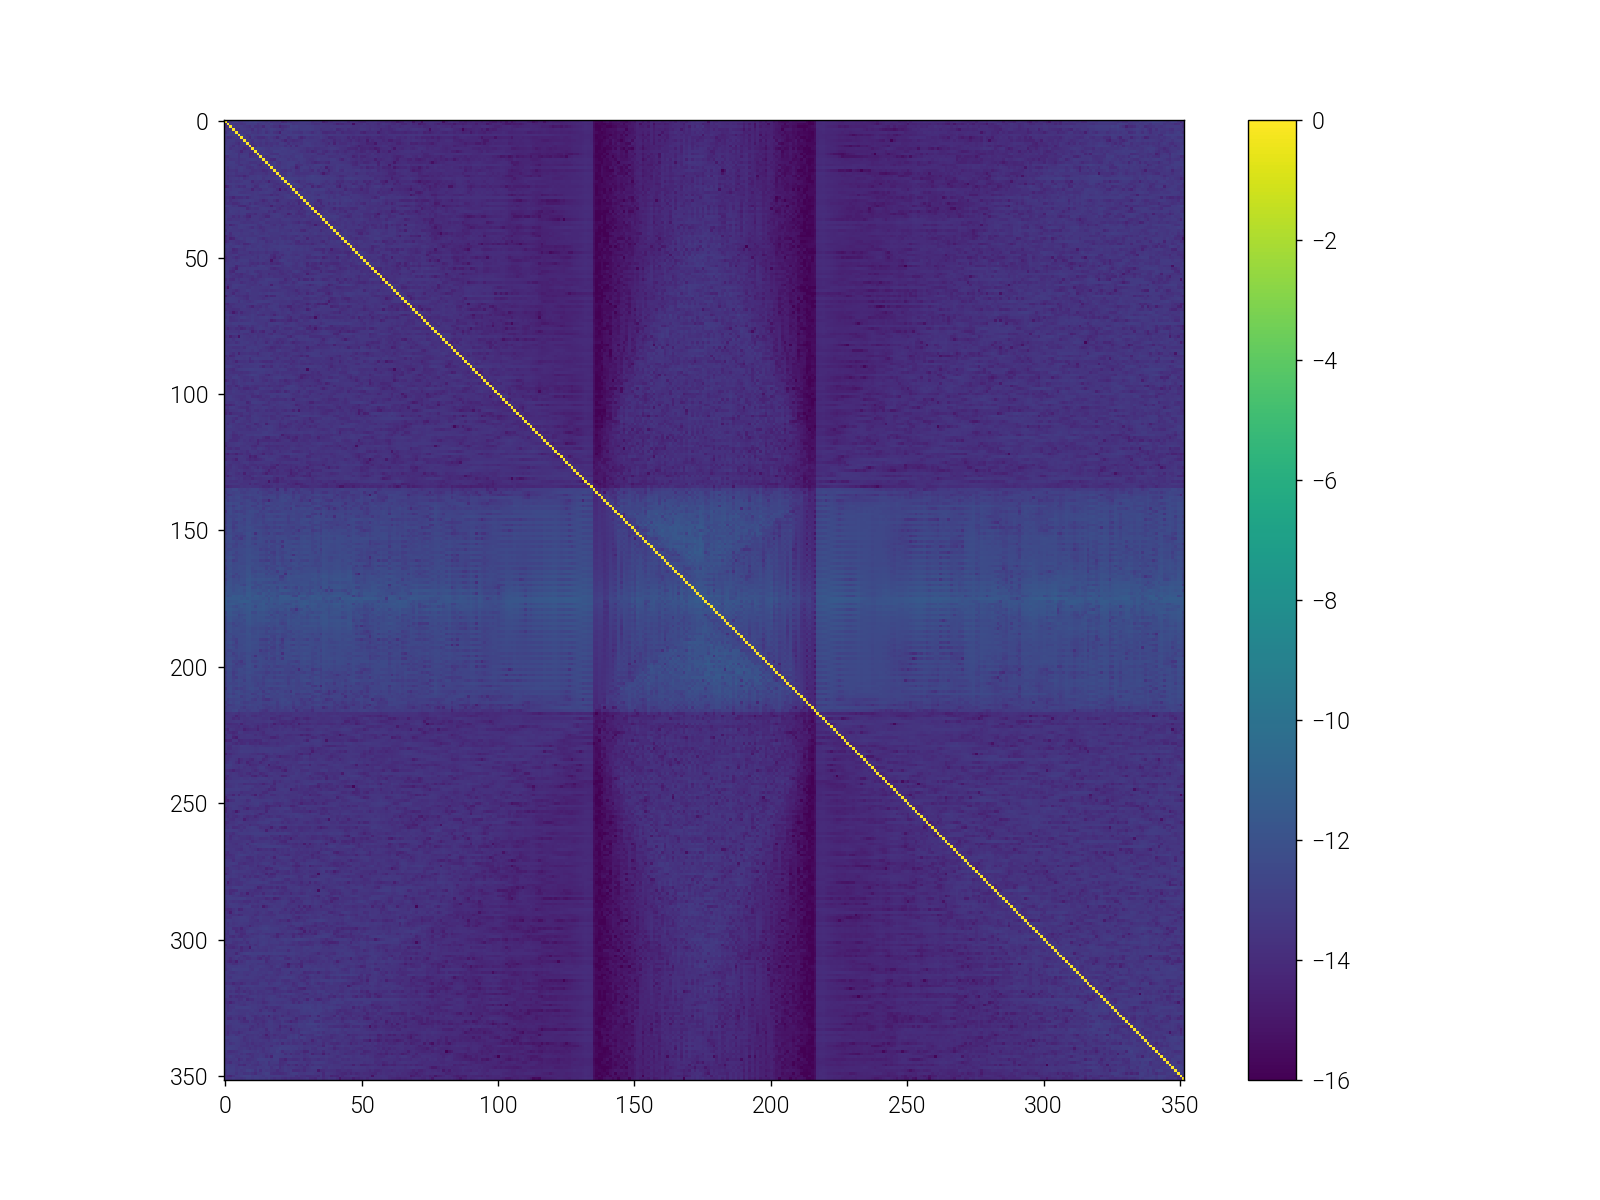

<IPython.core.display.Javascript object>


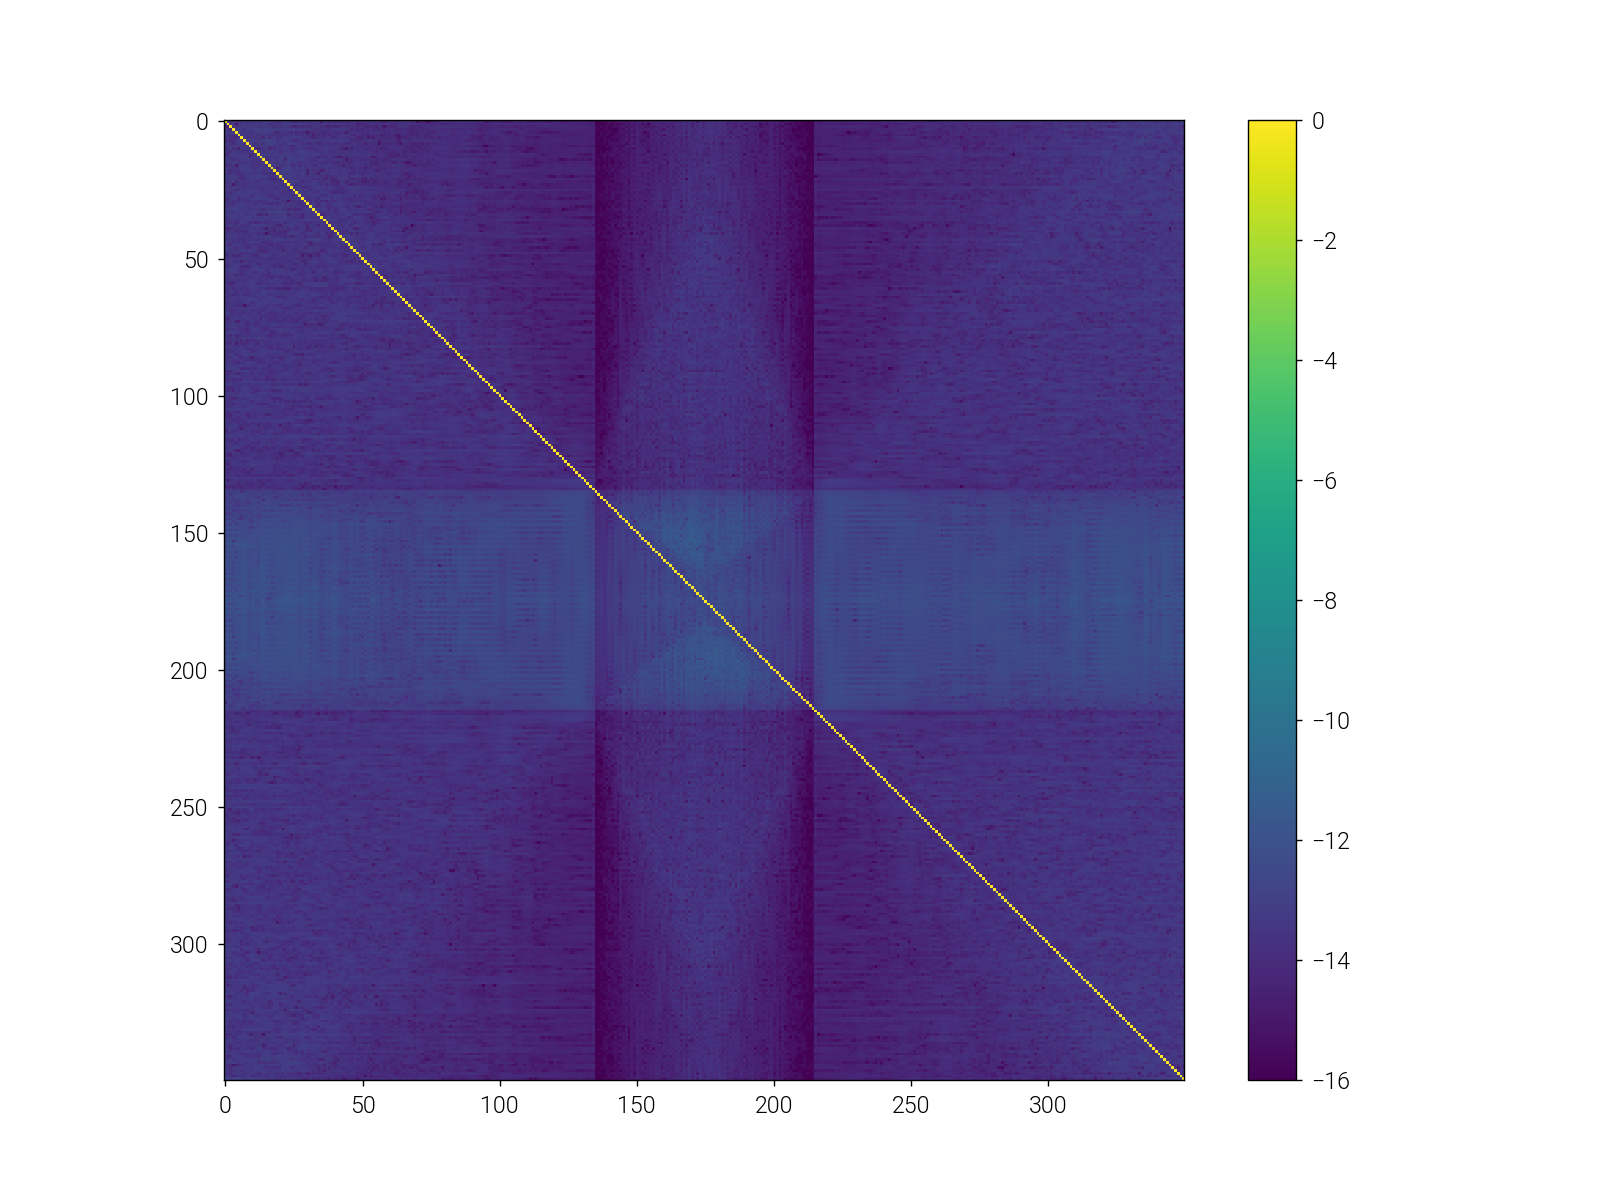

<IPython.core.display.Javascript object>


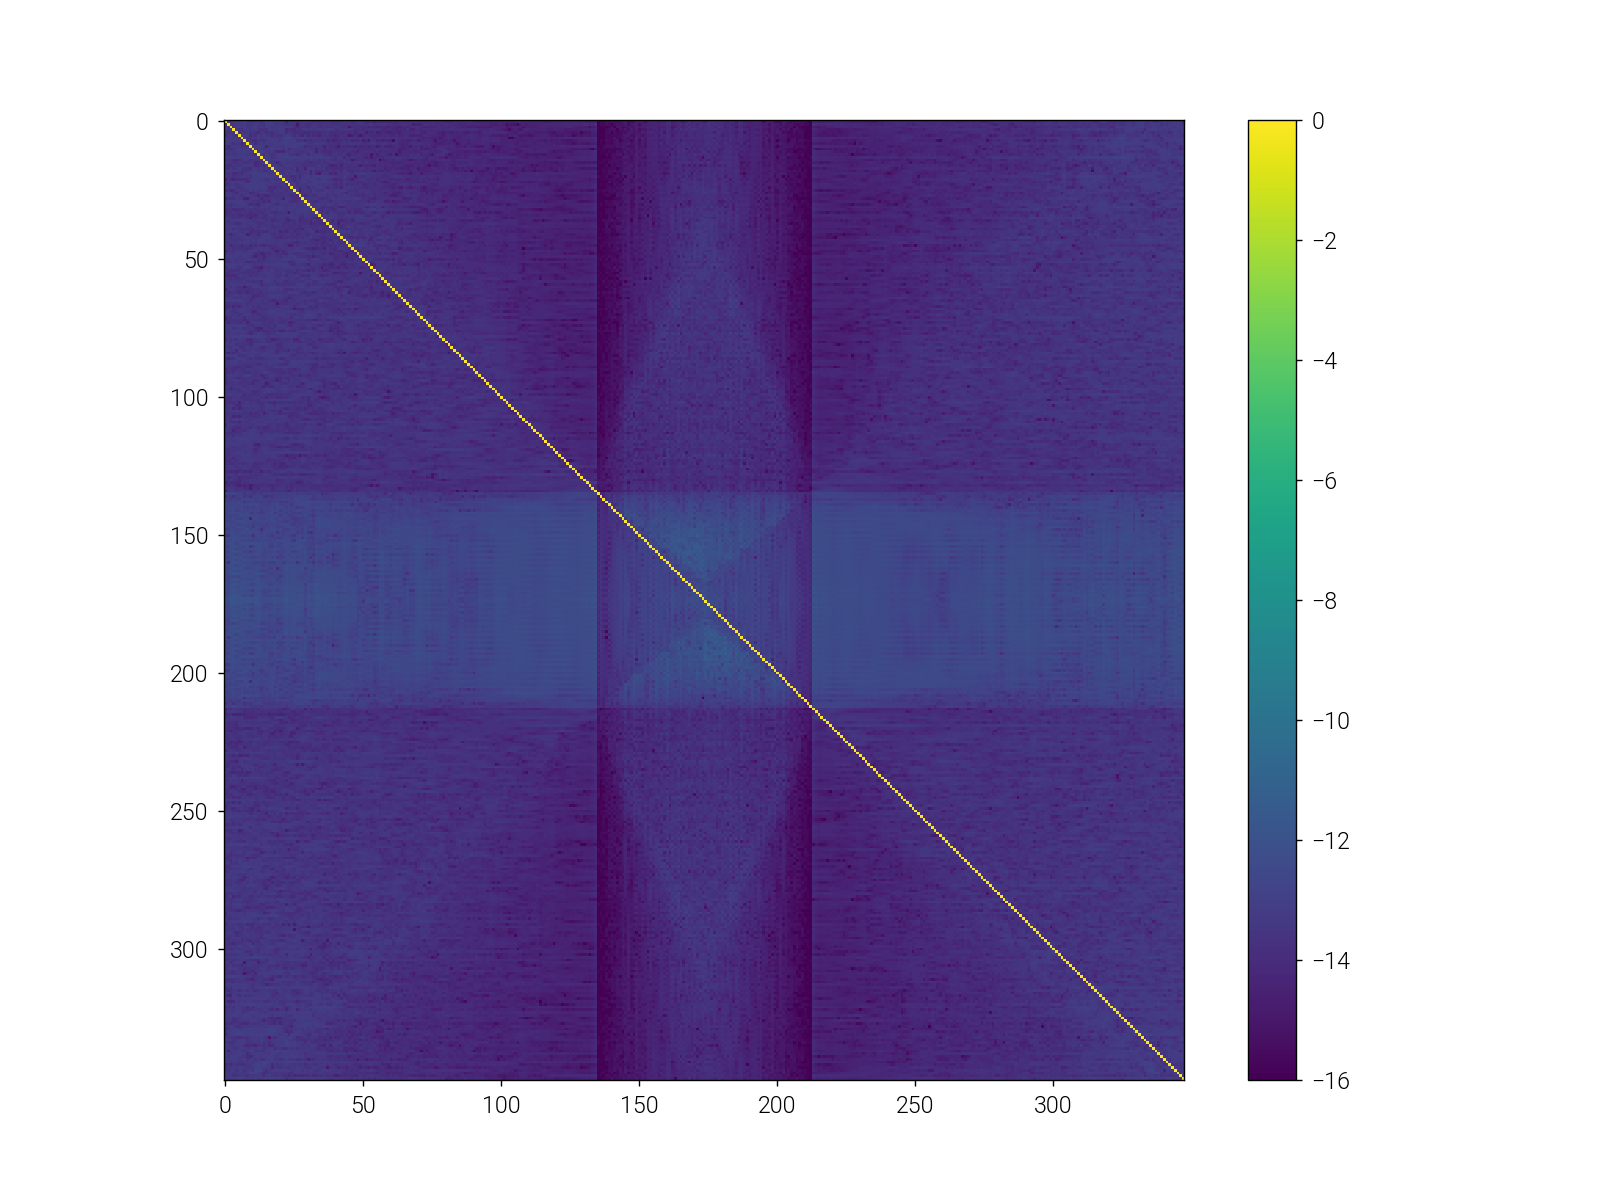

<IPython.core.display.Javascript object>


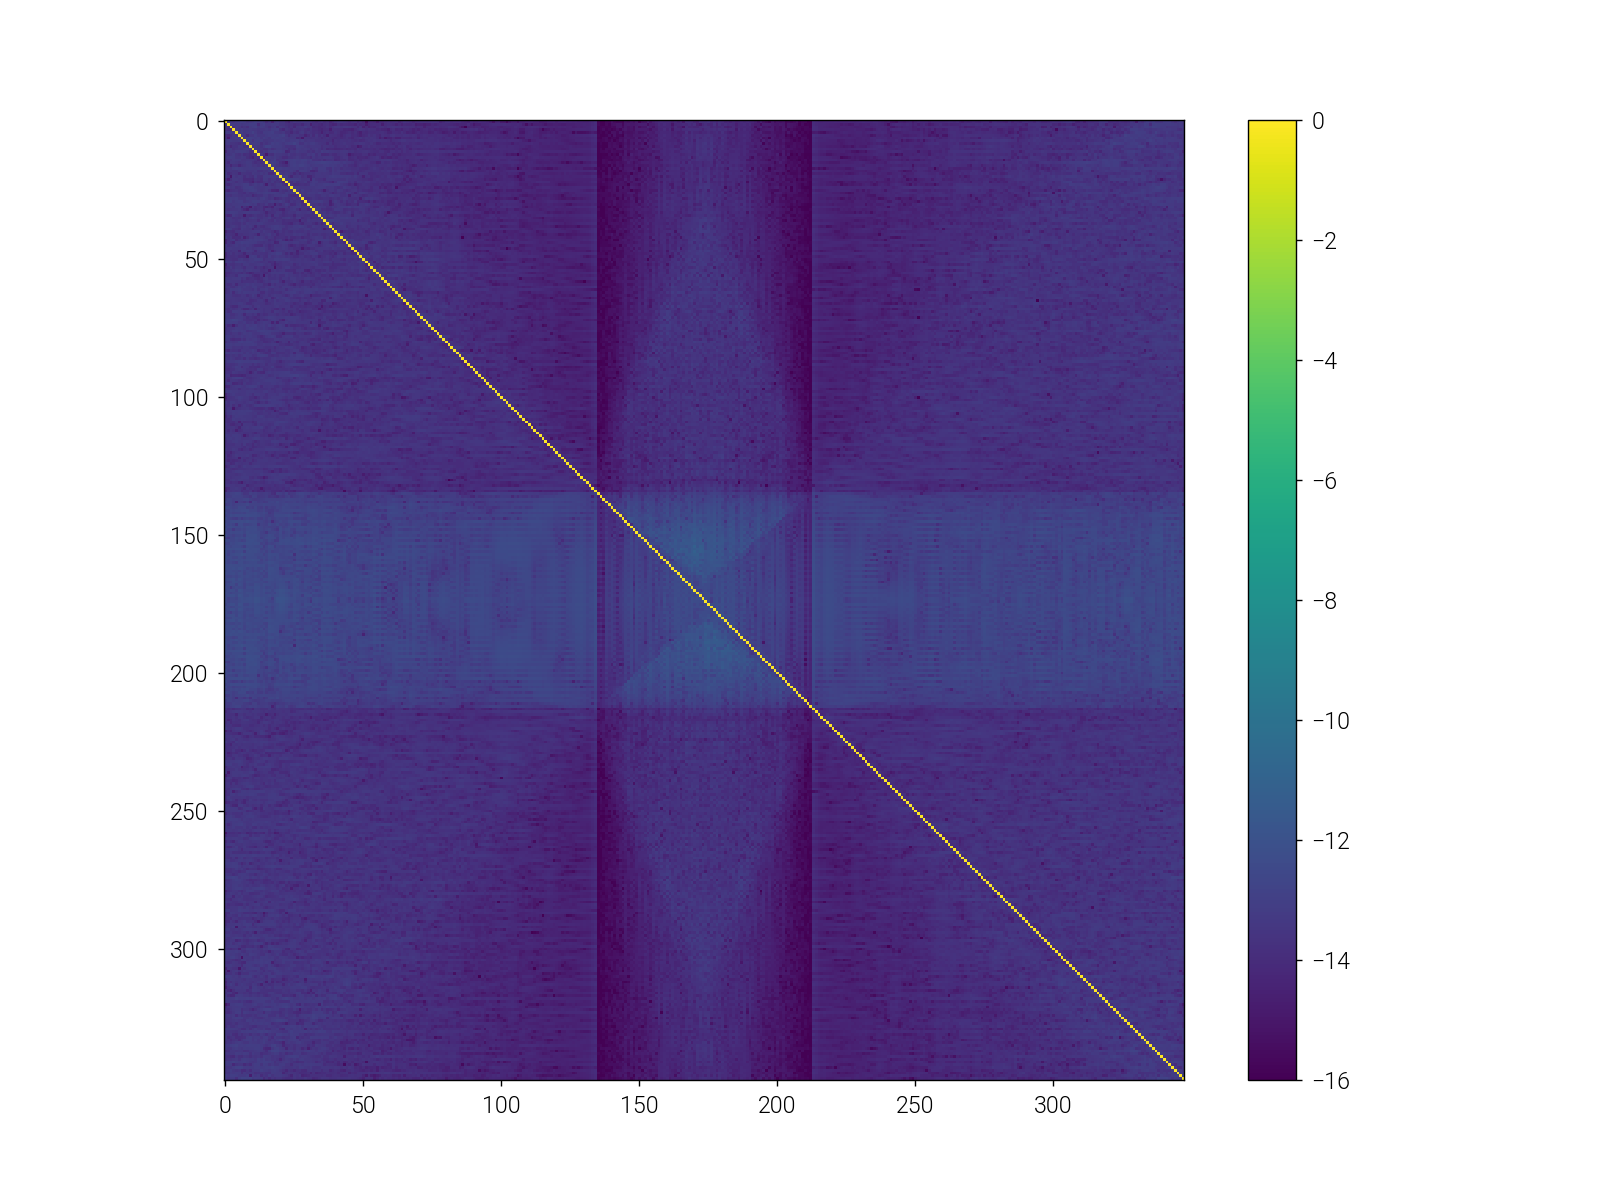

<IPython.core.display.Javascript object>


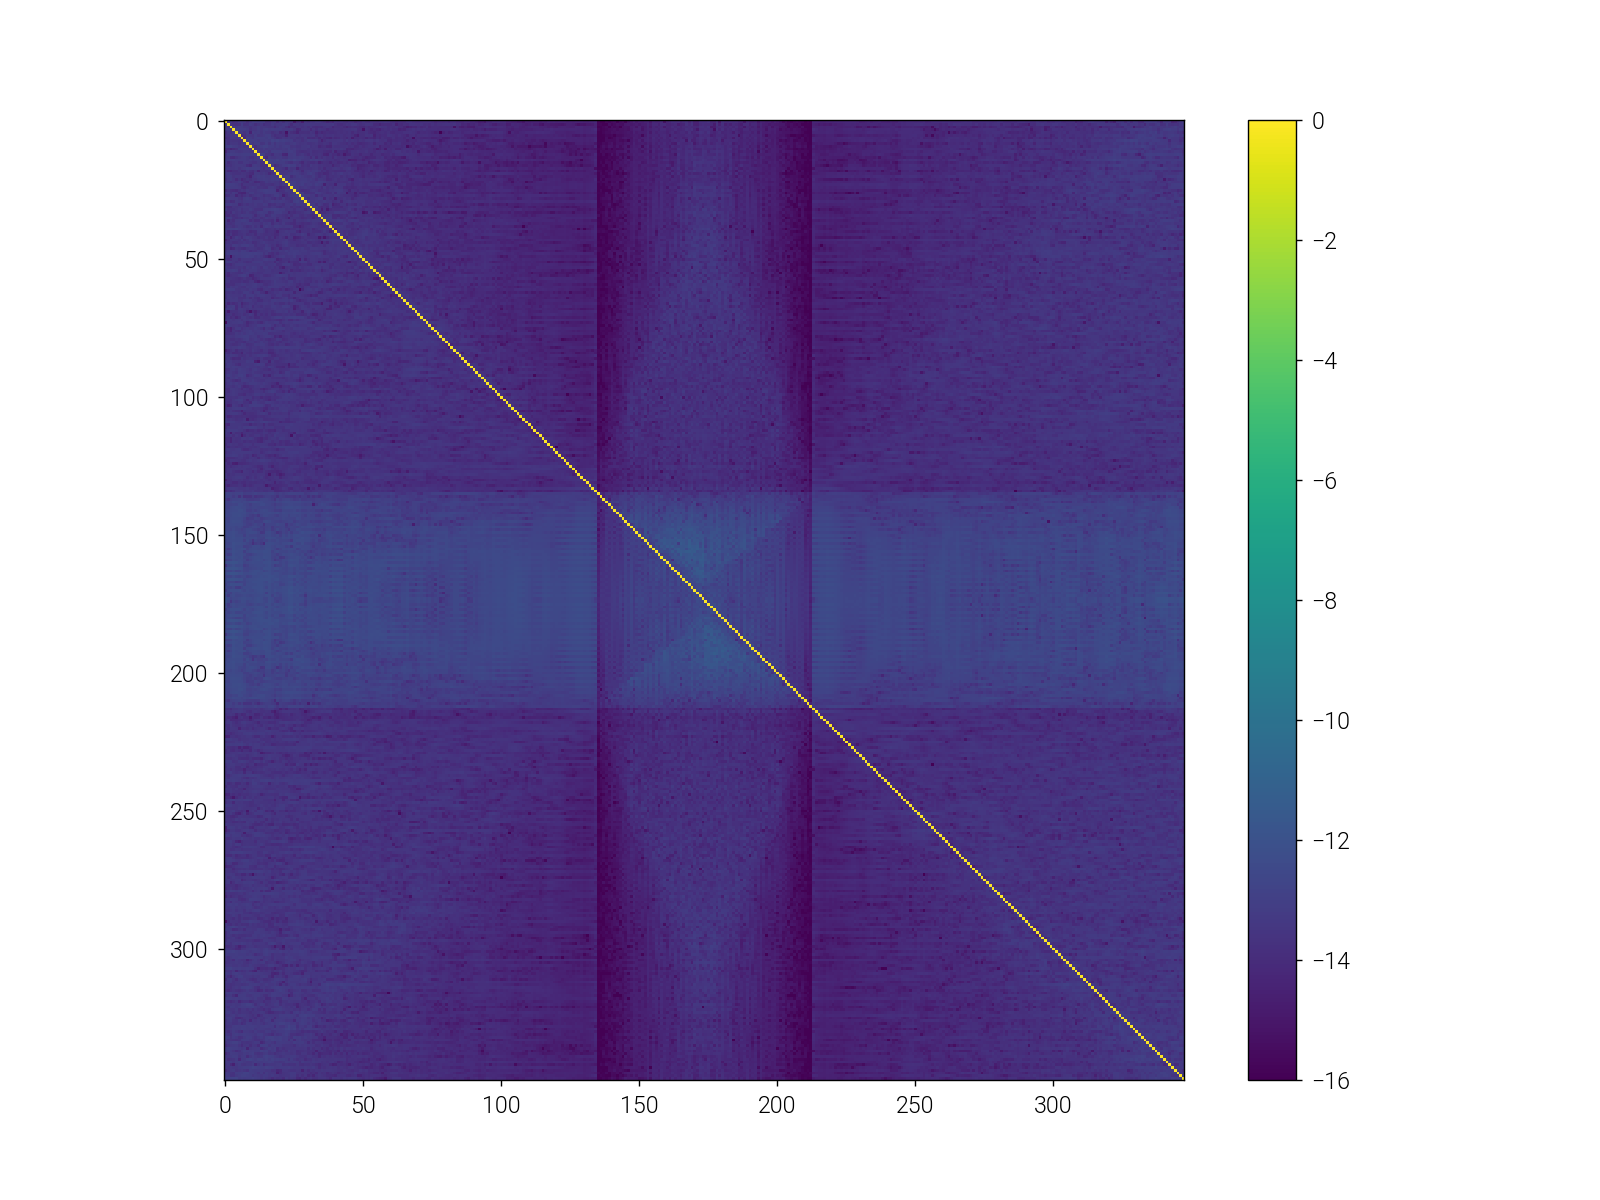

<IPython.core.display.Javascript object>


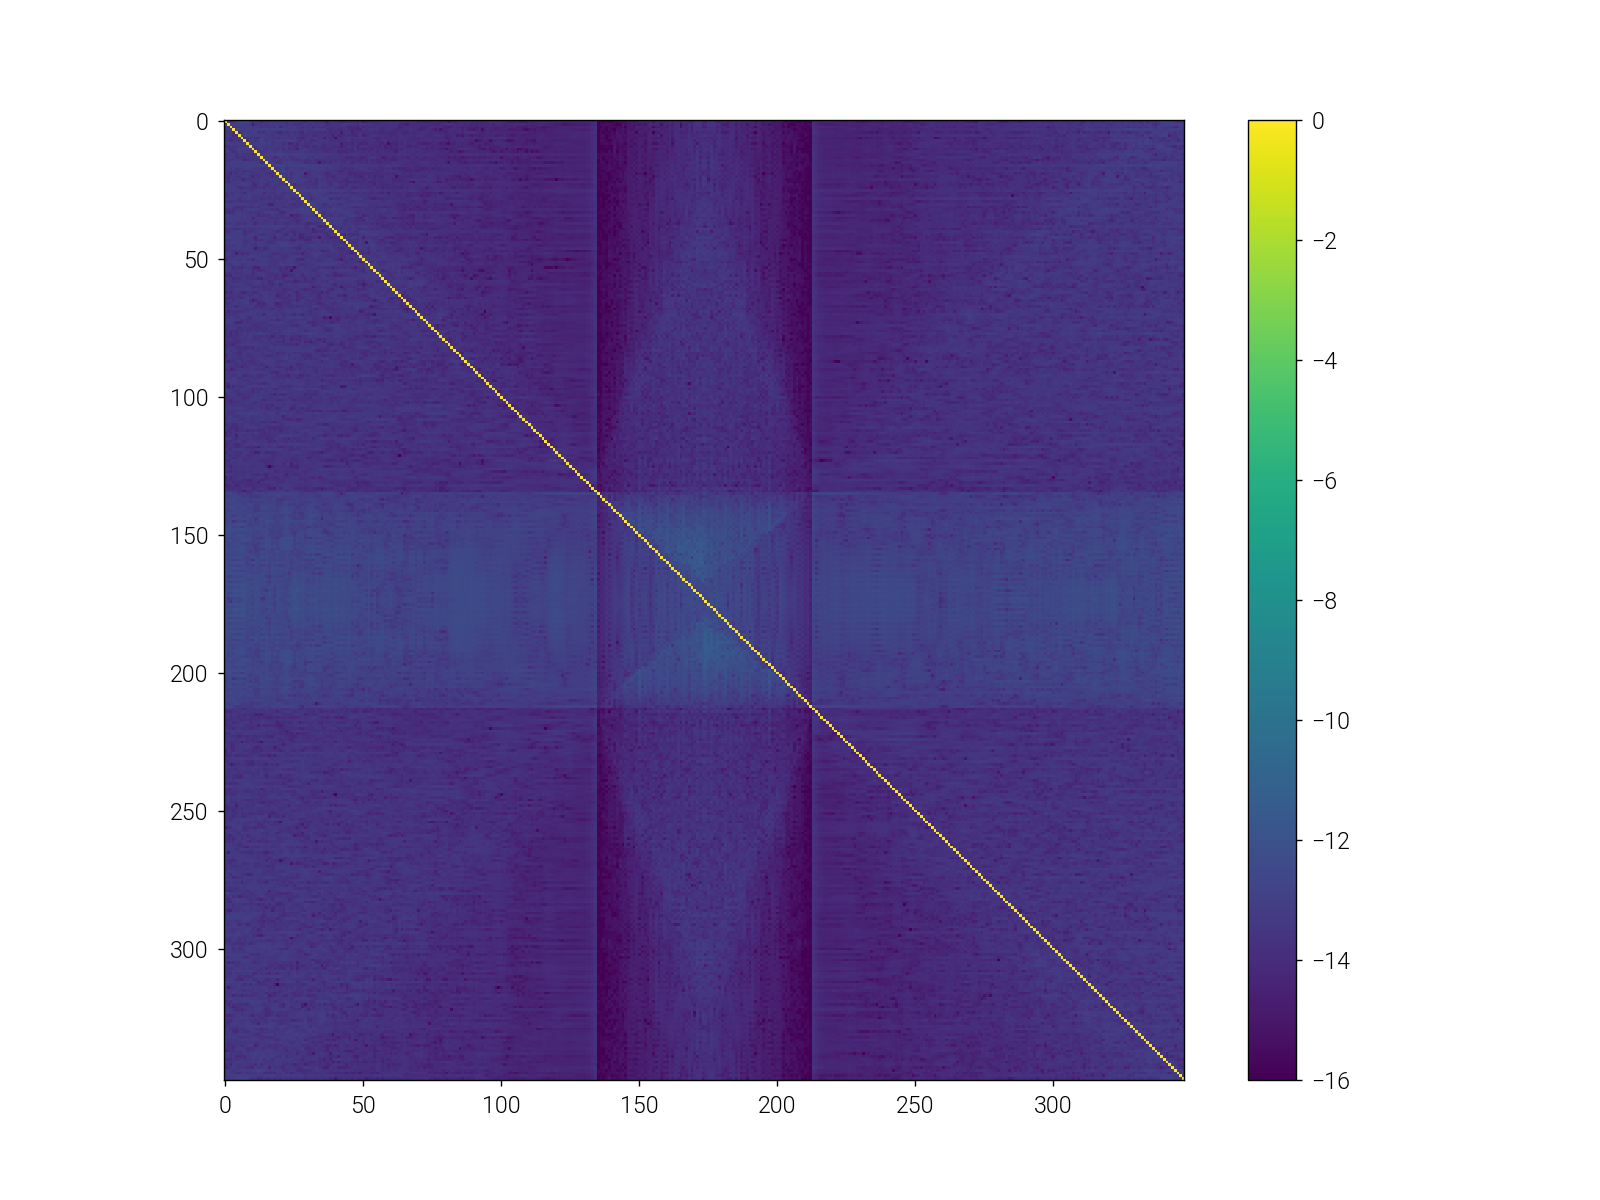

<IPython.core.display.Javascript object>


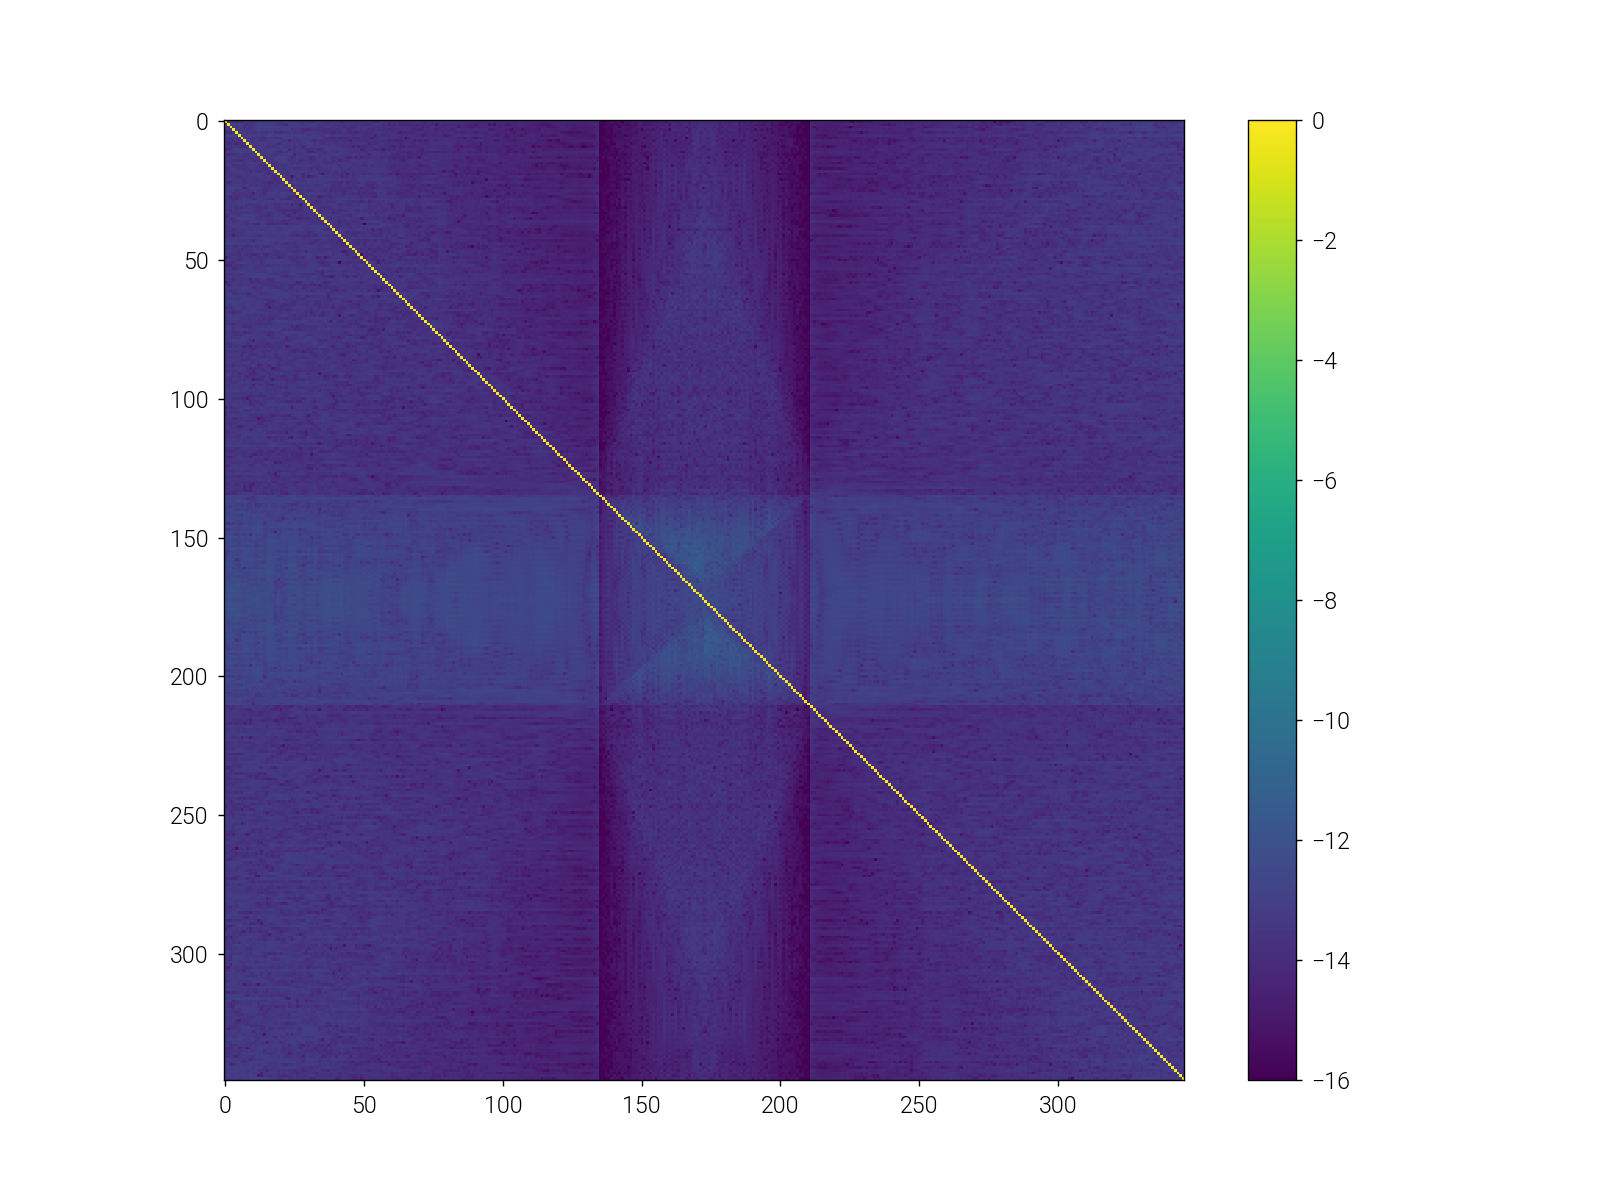

<IPython.core.display.Javascript object>


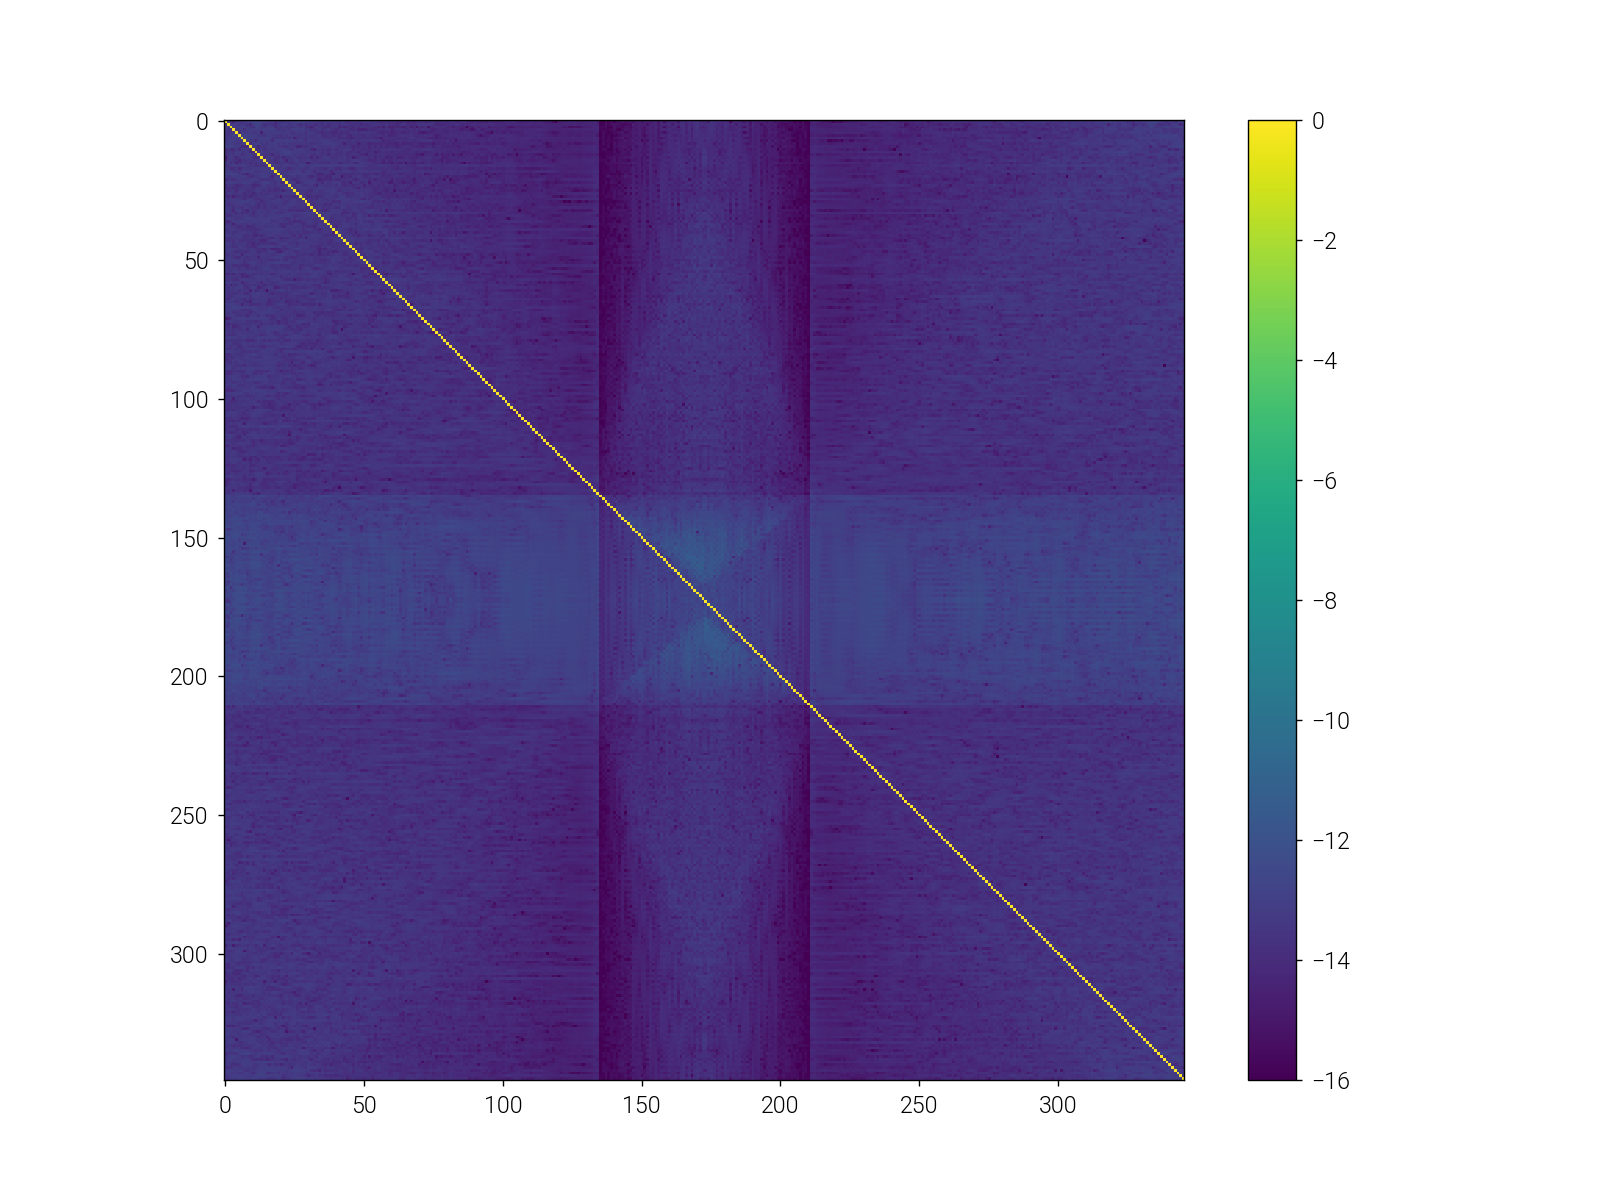

In [24]:
# Plot metrics
for krel in krel_list:
    evals, evecs, adj_evals, adj_evecs, proj, _, _ = eigenmodes[krel]
    filt = gen_filt(1j*evals)
    M = proj[filt,:] @ evecs[:,filt]
    plt.figure()
    plt.imshow(np.log10(np.abs(M)), cmap='viridis')
    plt.colorbar()
    plt.clim(-16, 0)

In [22]:
evals = shortmodes[0.5][0]
freqs = 1j * evals
filt = gen_filt(1j*evals)
filt_index = np.argmin(np.abs(2*freqs[filt].real-param.ω_tide))
print(freqs[filt][filt_index])

(0.014989827808875382-2.8359509540108117e-06j)


In [25]:
K = K_bLc_dict[(0.5,0.5)][filt_index, filt_index]
K

(0.01869026792864656+0.06812997872035936j)

In [43]:
A_range = np.linspace(0.005, 0.03, 1000)
growth = []
for A in A_range:
    Q = A*real_equiv_conj(K) + real_equiv(evals[filt][filt_index]-(-1j*0.5*param.ω_tide))
    freq = 1j * np.linalg.eigvals(Q)
    growth.append(np.max(freq.imag))

<IPython.core.display.Javascript object>


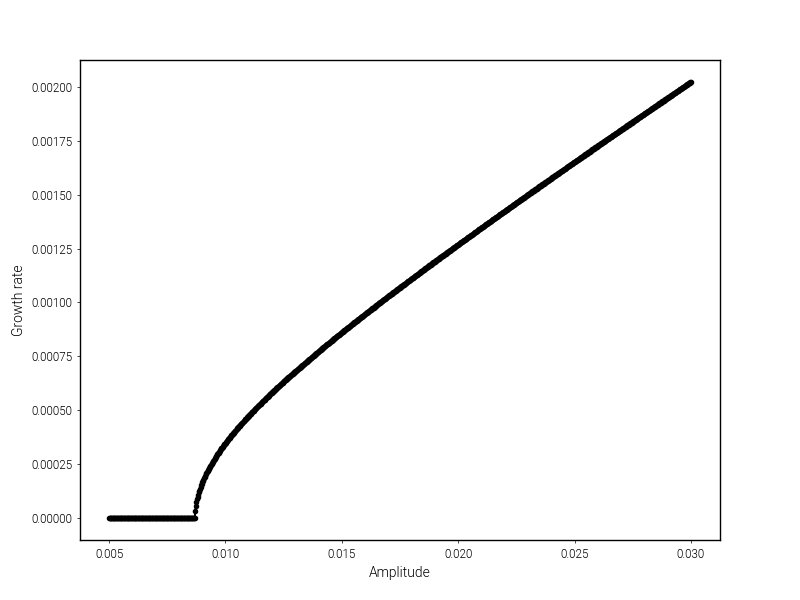

Text(0,0.5,'Growth rate')

In [44]:
plt.figure()
plt.plot(A_range, growth, '.-k')
plt.xlabel('Amplitude')
plt.ylabel('Growth rate')